### Problem Statement

1. What variables are important for predicting the selling price of a house?

In [4304]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
sns.set()

### Data Wrangling

In [4305]:
#read data into notebook

train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

In [4306]:
train = train.drop(columns=['Id','PID'])       #drop ID and PID columns as they are not helpful for getting correlations and predicting values
train['House Age']=train['Yr Sold']-train['Year Built']
train['Remod Age']=train['Yr Sold']-train['Year Remod/Add']
train = train.drop(columns=(['Garage Yr Blt','Mo Sold','Yr Sold','Year Built','Year Remod/Add']))   

#House age accounts for years built and sold. 
#Month Sold not likely to influence SalePrice because housing is a long-term commitment spanning years or decades.
#Year Remod/Add has moderately strong correlation with Year Built
#This reduces the number of nominal features that pandas will read as numerical ones as well.

cols = list(train.columns)
a, b, c = cols.index('SalePrice'), cols.index('House Age'), cols.index('Remod Age')
cols[b], cols[a] = cols[a], cols[b]
cols[b], cols[c] = cols[c], cols[b]
train=train[cols]
train.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Sale Type,House Age,Remod Age,SalePrice
0,60,RL,nan,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,WD,34,5,130500
1,60,RL,43.00000,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,WD,13,12,220000
2,20,RL,68.00000,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,WD,57,3,109000
3,60,RL,73.00000,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,WD,4,3,174000
4,50,RL,82.00000,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,WD,110,17,138500


In [4307]:
test = test.drop(columns=['Id','PID'])         #drop ID and PID columns as they are not helpful for getting correlations and predicting values
test['House Age']=test['Yr Sold']-test['Year Built']
test['Remod Age']=test['Yr Sold']-test['Year Remod/Add']
test = test.drop(columns=(['Garage Yr Blt','Mo Sold','Yr Sold','Year Built','Year Remod/Add']))

test.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Sale Type,House Age,Remod Age
0,190,RM,69.00000,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,WD,96,56
1,90,RL,nan,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,WD,29,29
2,60,RL,58.00000,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,New,0,0
3,30,RM,60.00000,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,WD,84,1
4,20,RL,nan,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,185,0,NaN,NaN,NaN,0,WD,46,46


In [4308]:
train.dtypes

MS SubClass         int64
MS Zoning          object
Lot Frontage      float64
Lot Area            int64
Street             object
Alley              object
Lot Shape          object
Land Contour       object
Utilities          object
Lot Config         object
Land Slope         object
Neighborhood       object
Condition 1        object
Condition 2        object
Bldg Type          object
House Style        object
Overall Qual        int64
Overall Cond        int64
Roof Style         object
Roof Matl          object
Exterior 1st       object
Exterior 2nd       object
Mas Vnr Type       object
Mas Vnr Area      float64
Exter Qual         object
Exter Cond         object
Foundation         object
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
                   ...   
Full Bath           int64
Half Bath           int64
Bedroom AbvGr       int64
Kitchen AbvGr       int64
Kitchen Qual       object
TotRms AbvGrd       int64
Functional         object
Fireplaces  

In [4309]:
test.dtypes

MS SubClass         int64
MS Zoning          object
Lot Frontage      float64
Lot Area            int64
Street             object
Alley              object
Lot Shape          object
Land Contour       object
Utilities          object
Lot Config         object
Land Slope         object
Neighborhood       object
Condition 1        object
Condition 2        object
Bldg Type          object
House Style        object
Overall Qual        int64
Overall Cond        int64
Roof Style         object
Roof Matl          object
Exterior 1st       object
Exterior 2nd       object
Mas Vnr Type       object
Mas Vnr Area      float64
Exter Qual         object
Exter Cond         object
Foundation         object
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
                   ...   
Bsmt Half Bath      int64
Full Bath           int64
Half Bath           int64
Bedroom AbvGr       int64
Kitchen AbvGr       int64
Kitchen Qual       object
TotRms AbvGrd       int64
Functional  

In [4310]:
train_desc_num = train.describe().transpose()
train_desc_num

,count,mean,std,min,25%,50%,75%,max
MS SubClass,2051.00000,57.00878,42.82422,20.00000,20.00000,50.00000,70.00000,190.00000
Lot Frontage,1721.00000,69.05520,23.26065,21.00000,58.00000,68.00000,80.00000,313.00000
Lot Area,2051.00000,10065.20819,6742.48891,1300.00000,7500.00000,9430.00000,11513.50000,159000.00000
Overall Qual,2051.00000,6.11214,1.42627,1.00000,5.00000,6.00000,7.00000,10.00000
Overall Cond,2051.00000,5.56216,1.10450,1.00000,5.00000,5.00000,6.00000,9.00000
Mas Vnr Area,2029.00000,99.69591,174.96313,0.00000,0.00000,0.00000,161.00000,1600.00000
BsmtFin SF 1,2050.00000,442.30049,461.20412,0.00000,0.00000,368.00000,733.75000,5644.00000
BsmtFin SF 2,2050.00000,47.95902,165.00090,0.00000,0.00000,0.00000,0.00000,1474.00000
Bsmt Unf SF,2050.00000,567.72829,444.95479,0.00000,220.00000,474.50000,811.00000,2336.00000
Total Bsmt SF,2050.00000,1057.98780,449.41070,0.00000,793.00000,994.50000,1318.75000,6110.00000


In [4311]:
train_desc_str= train.describe(include=['O']).transpose()
train_desc_str

,count,unique,top,freq
MS Zoning,2051,7,RL,1598
Street,2051,2,Pave,2044
Alley,140,2,Grvl,85
Lot Shape,2051,4,Reg,1295
Land Contour,2051,4,Lvl,1843
Utilities,2051,3,AllPub,2049
Lot Config,2051,5,Inside,1503
Land Slope,2051,3,Gtl,1953
Neighborhood,2051,28,NAmes,310
Condition 1,2051,9,Norm,1767


In [4312]:
def check_neg(df):
    df_desc_num = df.describe().transpose()
    df_neg_check = df_desc_num['min'].min()
    
    if df_neg_check >= 0.0:
        print("No negative values detected.")
    
    if df_neg_check < 0.0:
        print("Negative values detected!")

In [4313]:
check_neg(train)

Negative values detected!


In [4314]:
check_neg(test)

Negative values detected!


In [4315]:
print(len(train)) #find total number of rows in dataframe for comparison
print(len(test))

2051
879


In [4316]:
def make_nans_df(df):
    
    orig_cols = list(df.columns)
    
    #count number of nulls for cleaning
    df_nans = df.isnull().sum()        #find null values for all columns
    
    df_nans_dict = dict(df_nans)

    df_nans_missing_no_dict = {k:v/len(df) for k,v in df_nans_dict.items()}

    df_dtypes_dict = dict(df.dtypes)

    df_dtypes_dict = {k:v for k,v in dict(df_dtypes_dict).items()}

    df_nans_df = pd.DataFrame([df_nans_dict,df_nans_missing_no_dict,df_dtypes_dict],
                                 index=['missingno_count','missingno_perc','data_types'])
    df_nans_df = df_nans_df[orig_cols]
    
    df_nans_df = df_nans_df.transpose() #transpose dataframe to make it easy to read


    df_nans_df['missingno_count'] = pd.to_numeric(df_nans_df['missingno_count'])    #make missingno count numerical instead of object
    df_nans_df['missingno_perc'] = pd.to_numeric(df_nans_df['missingno_perc'])    #make missingno percentage numerical instead of object

    return df_nans_df

In [4317]:
train_nans_df = make_nans_df(train)  #call make_nans_df function to return a df containing all NaNs in the main DF

In [4318]:
train_nans_data = train_nans_df[train_nans_df['missingno_count']>0].sort_values(by='missingno_count',ascending=False)
train_nans_data.head()

,missingno_count,missingno_perc,data_types
Pool QC,2042,0.99561,object
Misc Feature,1986,0.96831,object
Alley,1911,0.93174,object
Fence,1651,0.80497,object
Fireplace Qu,1000,0.48757,object


In [4319]:
def get_unique_obj_dict(df):
    df_obj = df.select_dtypes(include=['object'])
    df_obj_unique = {}
    df_obj_cols = list(df_obj.columns)

    for i in range(0,len(df_obj_cols)):
        col_header = df_obj_cols[i]
        col_values = df[df_obj_cols[i]].unique().tolist()
        df_obj_unique[col_header] = col_values
    
    return df_obj_unique

train_unique_str = get_unique_obj_dict(train)

In [4320]:
#NA values, which are valid information according to the data dictionary, are likely to have been automatically interpreted as NaNs.
train_unique_str_nan = {k:v for k,v in train_unique_str.items() if any(pd.isnull(v))}
train_unique_str_nan

{'Alley': [nan, 'Pave', 'Grvl'],
 'Mas Vnr Type': ['BrkFace', 'None', nan, 'Stone', 'BrkCmn'],
 'Bsmt Qual': ['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'],
 'Bsmt Cond': ['TA', 'Gd', nan, 'Fa', 'Po', 'Ex'],
 'Bsmt Exposure': ['No', 'Gd', 'Av', nan, 'Mn'],
 'BsmtFin Type 1': ['GLQ', 'Unf', 'ALQ', 'Rec', nan, 'BLQ', 'LwQ'],
 'BsmtFin Type 2': ['Unf', 'Rec', nan, 'BLQ', 'GLQ', 'LwQ', 'ALQ'],
 'Fireplace Qu': [nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'],
 'Garage Type': ['Attchd',
  'Detchd',
  'BuiltIn',
  'Basment',
  nan,
  '2Types',
  'CarPort'],
 'Garage Finish': ['RFn', 'Unf', 'Fin', nan],
 'Garage Qual': ['TA', 'Fa', nan, 'Gd', 'Ex', 'Po'],
 'Garage Cond': ['TA', 'Fa', nan, 'Po', 'Gd', 'Ex'],
 'Pool QC': [nan, 'Fa', 'Gd', 'Ex', 'TA'],
 'Fence': [nan, 'MnPrv', 'GdPrv', 'GdWo', 'MnWw'],
 'Misc Feature': [nan, 'Shed', 'TenC', 'Gar2', 'Othr', 'Elev']}

 ### <span style = "color:green"> Cleaning Object NaNs: Part 1 </span>
Mas Vnr Type (Masonry Veneer Type) has both 'None' and 'NaN' values. It most likely has genuine missing values where 'nan' is reflected in the column.

In [4321]:
mask = pd.isnull(train['Mas Vnr Type'])
train_mvt_nans = train['Mas Vnr Type'][mask]
train_mvt_nans.head(5)

22     NaN
41     NaN
86     NaN
212    NaN
276    NaN
Name: Mas Vnr Type, dtype: object

In [4322]:
train['Mas Vnr Type'].fillna('None',inplace=True)
train['Mas Vnr Type'].value_counts(dropna=False)

None       1240
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

In [4323]:
test['Mas Vnr Type'].fillna('None',inplace=True)
test['Mas Vnr Type'].value_counts(dropna=False)

None       535
BrkFace    250
Stone       81
BrkCmn      12
CBlock       1
Name: Mas Vnr Type, dtype: int64

 ### <span style = "color:green"> Cleaning Object NaNs: Part 2 </span>

Mas Vnr Type was handled separately just in dropping NAs resulted in errors.

Garage Type is nominal, but 'NA' in its case still means 'None'.

The rest of the shortlisted object data are ordinal and for them, 'NA' also means 'None'. 

They also do not have both NaN and 'None' as entries.

It is thus safe to replace all NaNs with 'None'.

In [4324]:
for key in list(train_unique_str_nan.keys()):
    train[key].fillna('None',inplace=True)

train_str_cleaned = train[list(train_unique_str_nan.keys())]
train_str_cleaned.isnull().sum().sum()

0

#### Cleaning Int NaNs

For continuous variables, linear imputation by the mean without rounding will be used, because [it more closely reflects the real data](https://support.sas.com/resources/papers/proceedings/proceedings/sugi30/113-30.pdf).

For discrete variables, imputation by mode will be used.

 ### <span style = "color:green"> Cleaning Numerical NaNs</span>

In [4325]:
def check_int(v):
    return all(isinstance(x, int) for x in v)

def check_float(v):
    return all(isinstance(x, float) for x in v)

#get numerical columns containing numerical NaNs
def get_num_nan_cols(df):                         
    df_nans_num = df.select_dtypes(exclude=['object'])
    df_nans_float_cols = [k for k,v in df_nans_num.items() if check_float(v)]       #make separate lists for floats and ints because
    df_nans_int_cols = [k for k,v in df_nans_num.items() if check_int(v)]           #int columns contain ordinal categorical data entered as ints
    
    return df_nans_float_cols, df_nans_int_cols

train_nans_float_cols, train_nans_int_cols = get_num_nan_cols(train)
print("Float columns with NaNs: \n",train_nans_float_cols)
print("\nInt columns with NaNs: \n",train_nans_int_cols)



Float columns with NaNs: 
 ['Lot Frontage', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars', 'Garage Area']

Int columns with NaNs: 
 ['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'House Age', 'Remod Age', 'SalePrice']


In [4326]:
for float_col in train_nans_float_cols:
    train[float_col].fillna(train[float_col].median(),inplace=True) #fill NaNs in float columns using median values

In [4327]:
train[train.columns.intersection(train_nans_float_cols)].isnull().sum()

Lot Frontage      0
Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Cars       0
Garage Area       0
dtype: int64

In [4328]:
train[train.columns.intersection(train_nans_int_cols)].head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,House Age,Remod Age,SalePrice
0,60,13517,6,8,725,754,0,1479,2,1,...,0,44,0,0,0,0,0,34,5,130500
1,60,11492,7,5,913,1209,0,2122,2,1,...,0,74,0,0,0,0,0,13,12,220000
2,20,7922,5,7,1057,0,0,1057,1,0,...,0,52,0,0,0,0,0,57,3,109000
3,60,9802,5,5,744,700,0,1444,2,1,...,100,0,0,0,0,0,0,4,3,174000
4,50,14235,6,8,831,614,0,1445,2,0,...,0,59,0,0,0,0,0,110,17,138500


In [4329]:
train_nans_int_discrete_cols = ['MS SubClass','Overall Qual','Overall Cond',
                                'Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','House Age','Remod Age']
train_nans_int_cont_cols = [i for i in train_nans_int_cols if i not in train_nans_int_discrete_cols]

In [4330]:
for int_col in train_nans_int_discrete_cols:
    train[int_col].fillna(train[int_col].mode(),inplace=True) #fill NaNs in DISCRETE int columns using mode

In [4331]:
train[train.columns.intersection(train_nans_int_cont_cols)].isnull().sum()

Lot Area           0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Full Bath          0
Half Bath          0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
SalePrice          0
dtype: int64

In [4332]:
#any more NaNs in train data set?
train.isnull().sum().sum()

0

In [4333]:
train_num = train.select_dtypes(exclude='O').drop('MS SubClass',axis=1)
train_num = train_num.clip(lower=0)            

#Some negative values were created when creating House Age and Remod Age. 
#Possible that some houses were bought before construction or before remodelling.
#Such values were reduced to 0.

train[train_num.columns] = train_num
train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
MS SubClass,2051.00000,57.00878,42.82422,20.00000,20.00000,50.00000,70.00000,190.00000
Lot Frontage,2051.00000,68.88542,21.30989,21.00000,60.00000,68.00000,78.00000,313.00000
Lot Area,2051.00000,10065.20819,6742.48891,1300.00000,7500.00000,9430.00000,11513.50000,159000.00000
Overall Qual,2051.00000,6.11214,1.42627,1.00000,5.00000,6.00000,7.00000,10.00000
Overall Cond,2051.00000,5.56216,1.10450,1.00000,5.00000,5.00000,6.00000,9.00000


# <span style="color:green">Cleaning Test Data</span>

In [4334]:
test_nans_df = make_nans_df(test)
test_nans_df.head()

,missingno_count,missingno_perc,data_types
MS SubClass,0,0.00000,int64
MS Zoning,0,0.00000,object
Lot Frontage,160,0.18203,float64
Lot Area,0,0.00000,int64
Street,0,0.00000,object


In [4335]:
test_nans_data = test_nans_df[test_nans_df['missingno_count']>0].sort_values(by='missingno_count',ascending=False)
test_nans_data.head()

,missingno_count,missingno_perc,data_types
Pool QC,875,0.99545,object
Misc Feature,838,0.95336,object
Alley,821,0.93402,object
Fence,707,0.80432,object
Fireplace Qu,422,0.48009,object


In [4336]:
test_unique_str = get_unique_obj_dict(test)

In [4337]:
#NA values, which are valid information according to the data dictionary, are likely to have been automatically interpreted as NaNs.
test_unique_str_nan = {k:v for k,v in test_unique_str.items() if any(pd.isnull(v))}
test_unique_str_nan

{'Alley': ['Grvl', nan, 'Pave'],
 'Bsmt Qual': ['Fa', 'Gd', 'TA', 'Ex', nan, 'Po'],
 'Bsmt Cond': ['TA', 'Gd', nan, 'Fa'],
 'Bsmt Exposure': ['No', 'Av', nan, 'Mn', 'Gd'],
 'BsmtFin Type 1': ['Unf', 'GLQ', 'BLQ', 'Rec', 'ALQ', nan, 'LwQ'],
 'BsmtFin Type 2': ['Unf', 'LwQ', nan, 'ALQ', 'GLQ', 'Rec', 'BLQ'],
 'Electrical': ['FuseP', 'SBrkr', 'FuseA', 'FuseF', nan],
 'Fireplace Qu': [nan, 'Gd', 'Fa', 'TA', 'Po', 'Ex'],
 'Garage Type': ['Detchd',
  'Attchd',
  'BuiltIn',
  nan,
  '2Types',
  'CarPort',
  'Basment'],
 'Garage Finish': ['Unf', 'Fin', 'RFn', nan],
 'Garage Qual': ['Po', 'TA', 'Fa', nan, 'Gd'],
 'Garage Cond': ['Po', 'TA', nan, 'Fa', 'Gd', 'Ex'],
 'Pool QC': [nan, 'Ex', 'TA'],
 'Fence': [nan, 'MnPrv', 'GdPrv', 'GdWo', 'MnWw'],
 'Misc Feature': [nan, 'Shed', 'Othr', 'Gar2']}

In [4338]:
for key in list(test_unique_str_nan.keys()):
    test[key].fillna('None',inplace=True)

test_str_cleaned = test[list(test_unique_str_nan.keys())]
test_str_cleaned.isnull().sum().sum() #any more nulls?

0

In [4339]:
test_nans_float_cols, test_nans_int_cols = get_num_nan_cols(test)
print("Float columns with NaNs: \n",test_nans_float_cols)
print("\nInt columns with NaNs: \n",test_nans_int_cols)

Float columns with NaNs: 
 ['Lot Frontage', 'Mas Vnr Area']

Int columns with NaNs: 
 ['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'House Age', 'Remod Age']


In [4340]:
test_nans_int_discrete_cols = ['MS SubClass','Overall Qual','Overall Cond',
                                'Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','House Age','Remod Age']
test_nans_int_cont_cols = [i for i in test_nans_int_cols if i not in test_nans_int_discrete_cols]

In [4341]:
for float_col in test_nans_float_cols:
    test[float_col].fillna(test[float_col].median(),inplace=True) #fill NaNs in float columns using median values

In [4342]:
#any more nulls?
test.isnull().sum().sum()

0

In [4343]:
test_num = test.select_dtypes(exclude='O').drop('MS SubClass',axis=1)
test_num = test_num.clip(lower=0)            

#Some negative values were created when creating House Age and Remod Age. 
#Possible that some houses were bought before construction or before remodelling.
#Such values were reduced to 0.

test[test_num.columns] = test_num
test.describe().T

,count,mean,std,min,25%,50%,75%,max
MS SubClass,879.00000,58.27076,42.21139,20.00000,20.00000,50.00000,70.00000,190.00000
Lot Frontage,879.00000,69.33333,21.37381,21.00000,60.00000,68.00000,78.50000,182.00000
Lot Area,879.00000,10340.92036,10047.33517,1477.00000,7298.50000,9453.00000,11606.50000,215245.00000
Overall Qual,879.00000,6.05461,1.37476,2.00000,5.00000,6.00000,7.00000,10.00000
Overall Cond,879.00000,5.56542,1.12842,1.00000,5.00000,5.00000,6.00000,9.00000
Mas Vnr Area,879.00000,106.86121,188.28411,0.00000,0.00000,0.00000,173.00000,1378.00000
BsmtFin SF 1,879.00000,443.39704,442.48022,0.00000,0.00000,374.00000,735.50000,2288.00000
BsmtFin SF 2,879.00000,53.83504,178.53985,0.00000,0.00000,0.00000,0.00000,1526.00000
Bsmt Unf SF,879.00000,539.51877,426.08273,0.00000,216.00000,453.00000,781.50000,2046.00000
Total Bsmt SF,879.00000,1036.75085,419.25843,0.00000,790.00000,975.00000,1248.00000,3138.00000


In [4344]:
train.to_csv('datasets/train_cleaned_no_dum.csv')
test.to_csv('datasets/test_cleaned_no_dum.csv')

# Exploratory Data Analysis

In [4345]:
def subplot_num_hist(df,list_of_columns,fs=(15,15),cwrap=3,threshold=0.8):
    nrows = int(np.ceil(len(list_of_columns)/cwrap)) # Makes sure you have enough rows
                
    fig, ax= plt.subplots(nrows=nrows, ncols=cwrap,figsize=fs) # You'll want to specify your figsize
                
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    excl_thresh = threshold*len(df)
    
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(x=df[column])
        ax[i].set_title(column,fontsize=16)
        ax[i].axhline(y=excl_thresh,color='pink',label='Exclusion Threshold')
        ax[i].axvline(x=df[column].median(),color='g',label='Median '+(column).capitalize())
        ax[i].axvline(x=df[column].mean(),color='r',ls='--',label='Mean '+(column).capitalize())
        ax[i].legend()
    plt.tight_layout()
    plt.show()

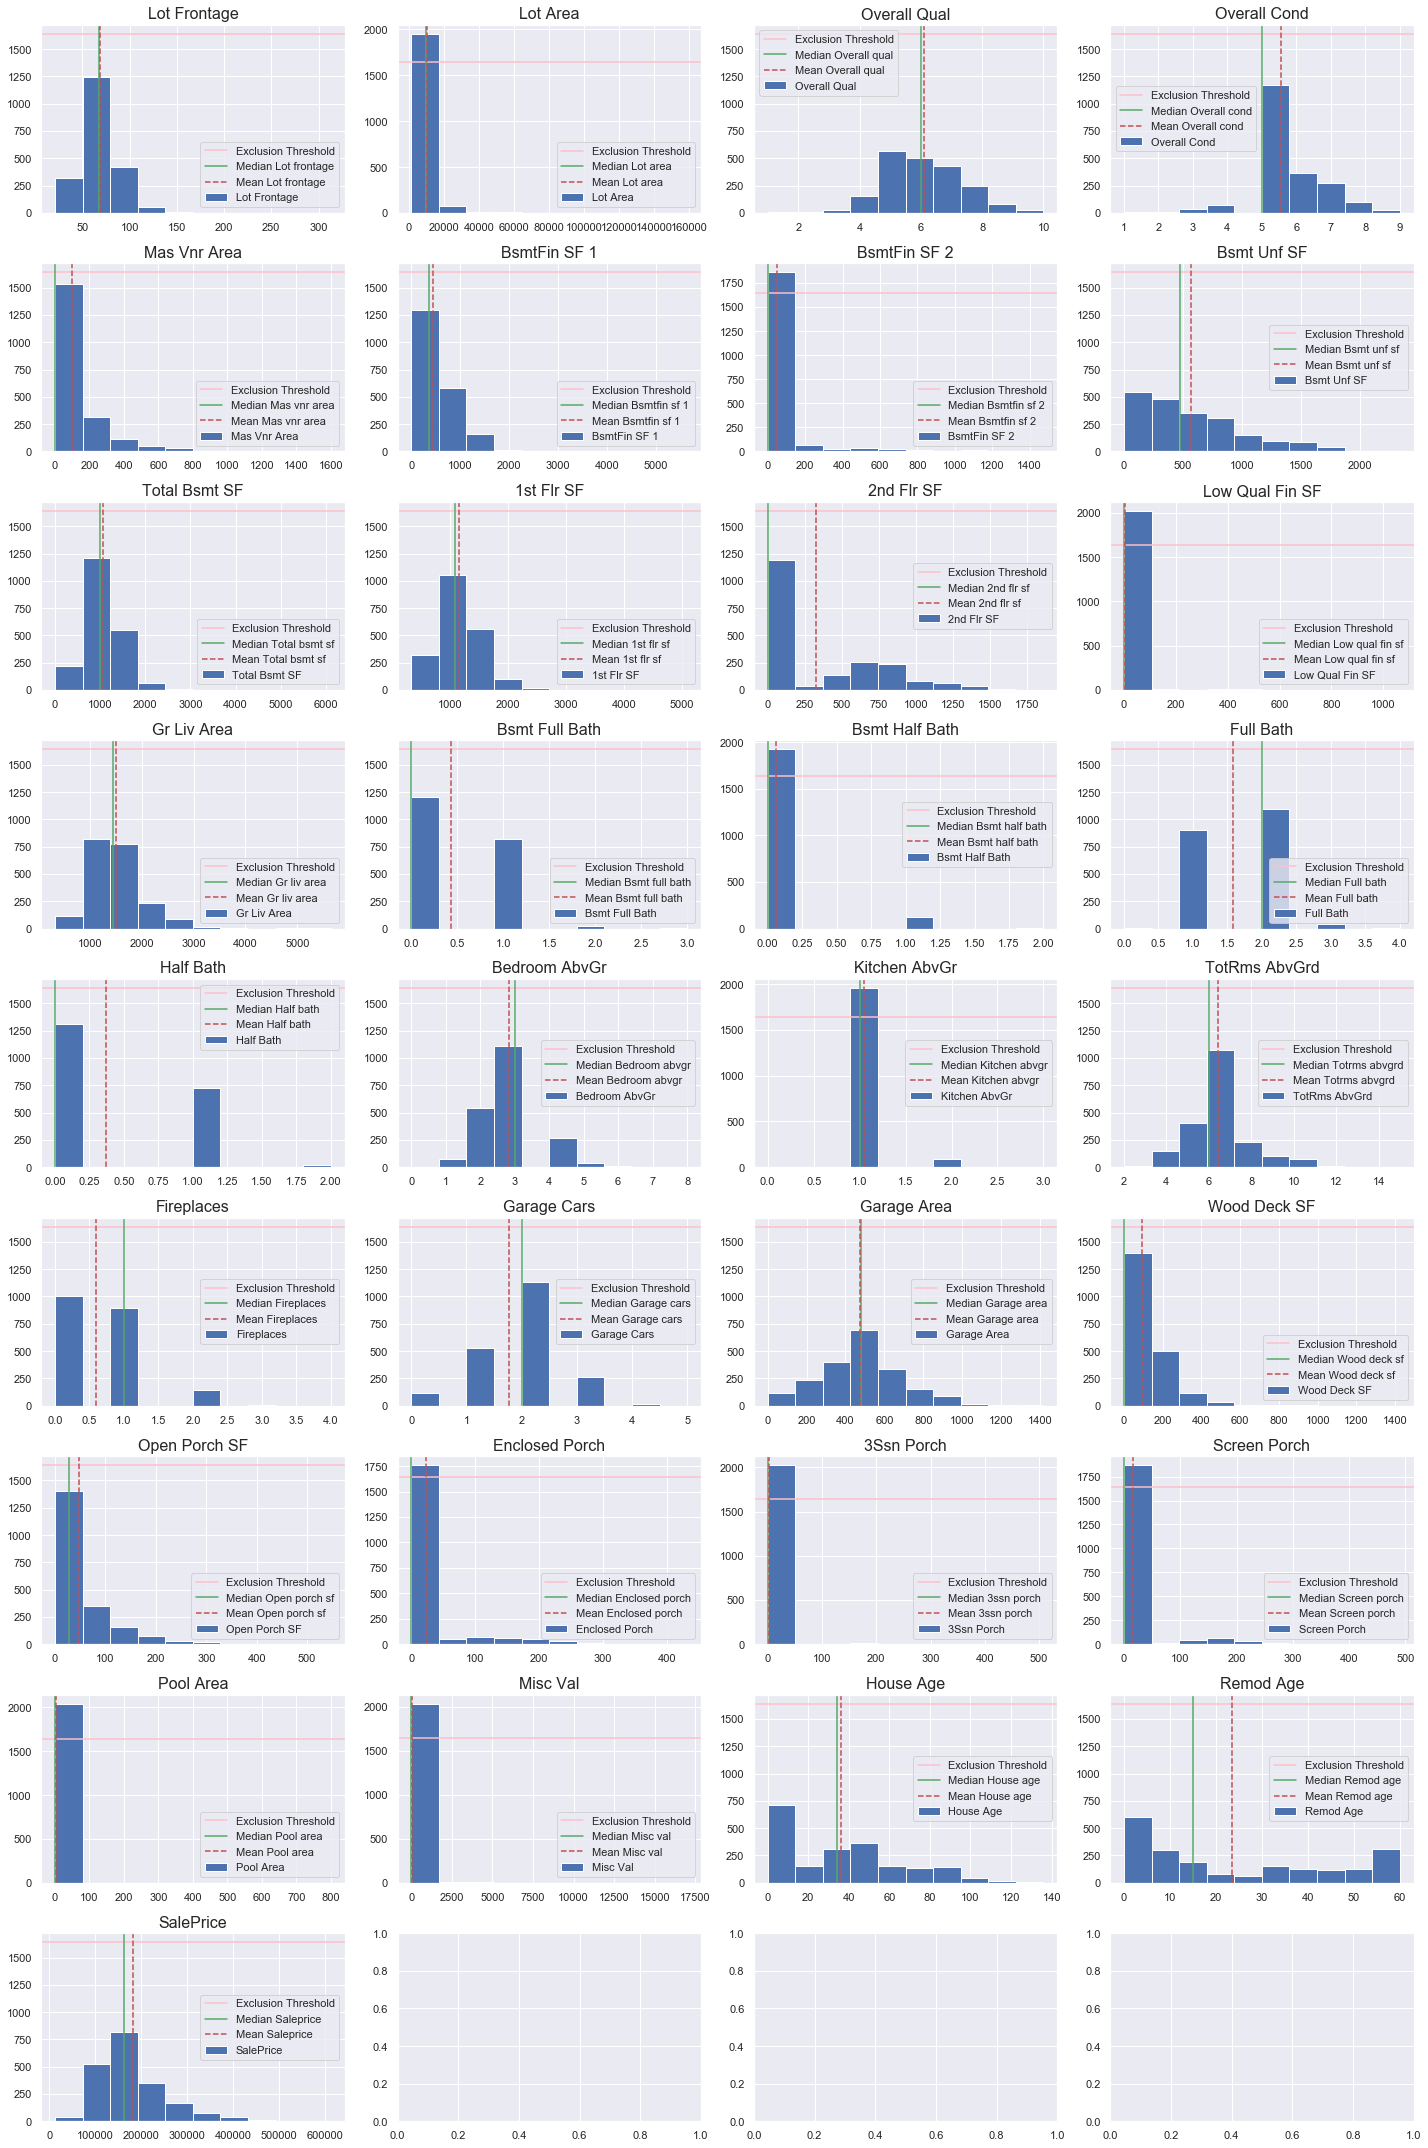

In [4346]:
subplot_num_hist(train_num,list(train_num.columns),fs=(20,30),cwrap=4)

In [4347]:
def kill_outliers_iqr(df):
    for col, vals in df.iteritems():
        Q1 = vals.quantile(0.25)
        Q3 = vals.quantile(0.75)
        IQR = Q3 - Q1
        df = df.loc[(df[col] > (Q1 - 1.8 * IQR)) & (df[col] < (Q1 + 1.8 * IQR))]   
        #Slightly relaxed the boundaries to avoid dropping too many rows
        return df

In [4348]:
train_num_iqr = kill_outliers_iqr(train_num)
rows_dropped = len(train_num) - len(train_num_iqr)
perc_dropped = rows_dropped/len(train_num)
print("Rows dropped:",rows_dropped)
print("Perc dropped:",perc_dropped)

Rows dropped: 259
Perc dropped: 0.12627986348122866


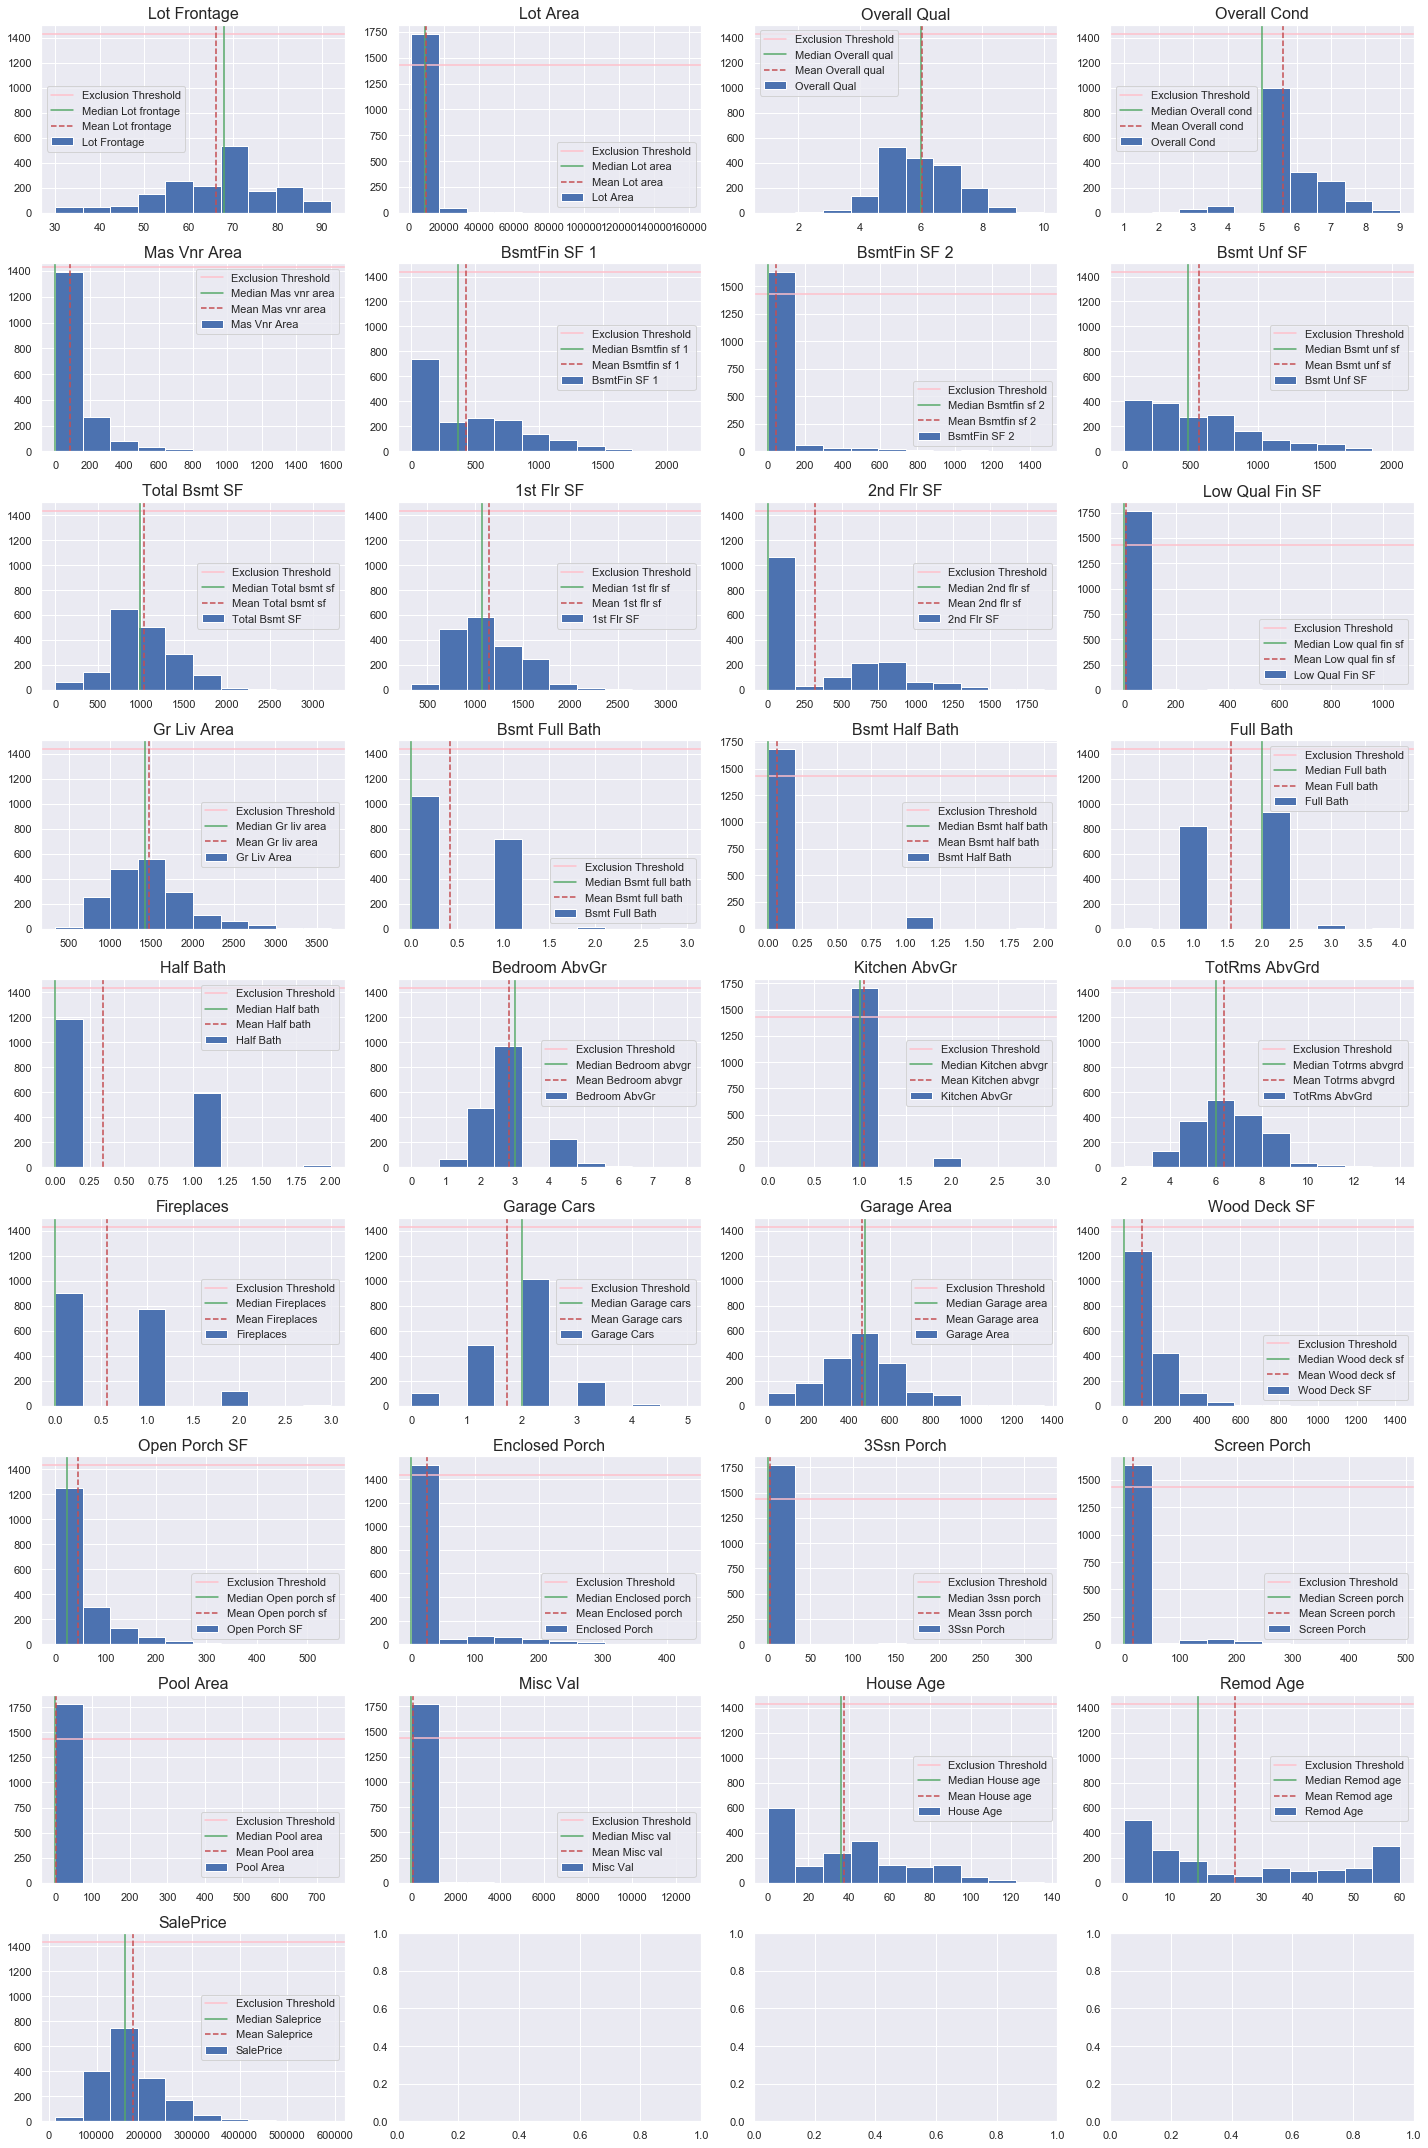

In [4349]:
subplot_num_hist(train_num_iqr,list(train_num_iqr.columns),fs=(20,30),cwrap=4)

In [4350]:
train_num_cols = list(train_num_iqr.columns)
train_num_drop = ['Lot Area','Mas Vnr Area','BsmtFin SF 2','Low Qual Fin SF','Bsmt Half Bath',
                 'Kitchen AbvGr','Wood Deck SF','Enclosed Porch','3Ssn Porch',
                 'Screen Porch','Pool Area','Misc Val']
train_num_keep = [i for i in train_num_cols if i not in train_num_drop]

In [4351]:
train = train.drop(train_num_drop,axis=1)
train_num = train.select_dtypes(exclude='O').drop('MS SubClass',axis=1)
test = test.drop(train_num_drop,axis=1)

#if columns in train are not being used, the same columns should not be used in test set

In [4352]:
new_train_index = train_num_iqr.index
new_train = train.loc[[i for i in train.index if i in new_train_index]] #get same columns for all data
y = new_train['SalePrice']
print("New row count:",len(new_train))
print("Proportion vs. test set count",len(new_train)/len(test))

New row count: 1792
Proportion vs. test set count 2.0386803185437996


Used Interquartile Range to identify and drop rows with outlier data.

New data set should be more representative of "typical" house sales, which we are more interested in.

Remaining rows are almost roughly 2x the rows of test set, so that should provide close to a 2:1 split.

Test data rows will not be dropped; this will aid in testing the model's robustness versus unseen data.

In [4353]:
train_num = new_train.select_dtypes(exclude='O').drop(['MS SubClass'],axis=1)
train_num.head()

,Lot Frontage,Overall Qual,Overall Cond,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,...,Half Bath,Bedroom AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Open Porch SF,House Age,Remod Age,SalePrice
0,68.00000,6.00000,8.00000,533.00000,192.00000,725.00000,725.00000,754.00000,1479.00000,0.00000,...,1.00000,3.00000,6.00000,0.00000,2.00000,475.00000,44.00000,34.00000,5.00000,130500.00000
1,43.00000,7.00000,5.00000,637.00000,276.00000,913.00000,913.00000,1209.00000,2122.00000,1.00000,...,1.00000,4.00000,8.00000,1.00000,2.00000,559.00000,74.00000,13.00000,12.00000,220000.00000
2,68.00000,5.00000,7.00000,731.00000,326.00000,1057.00000,1057.00000,0.00000,1057.00000,1.00000,...,0.00000,3.00000,5.00000,0.00000,1.00000,246.00000,52.00000,57.00000,3.00000,109000.00000
3,73.00000,5.00000,5.00000,0.00000,384.00000,384.00000,744.00000,700.00000,1444.00000,0.00000,...,1.00000,3.00000,7.00000,0.00000,2.00000,400.00000,0.00000,4.00000,3.00000,174000.00000
4,82.00000,6.00000,8.00000,0.00000,676.00000,676.00000,831.00000,614.00000,1445.00000,0.00000,...,0.00000,3.00000,6.00000,0.00000,2.00000,484.00000,59.00000,110.00000,17.00000,138500.00000


In [4354]:
def subplot_num_scatter(df,list_of_columns,target,fs=(15,15),cwrap=3):
    nrows = int(np.ceil(len(list_of_columns)/cwrap)) # Makes sure you have enough rows
                
    fig, ax= plt.subplots(nrows=nrows, ncols=cwrap,figsize=fs) # You'll want to specify your figsize
                
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    model=LinearRegression()
    
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
                
        model.fit(df[[column]],df[[target]])
        y_pred = model.predict(df[[column]])
        ax[i].plot(df[column],y_pred,color='r',label='LR Line')
        ax[i].scatter(x=df[column],y=df[target])
        ax[i].set_title(target+" vs. "+column,fontsize=16)
        ax[i].axhline(y=df[target].median(),color='y',label='Median '+(target).capitalize())
        ax[i].axvline(x=df[column].median(),color='g',label='Median '+(column).capitalize())
        ax[i].axvline(x=df[column].mean(),color='r',ls='--',label='Mean '+(column).capitalize())
               
        
        
        ax[i].set_xlabel(column)
        ax[i].set_ylabel(target)
        ax[i].legend()
    plt.tight_layout()
    plt.show()

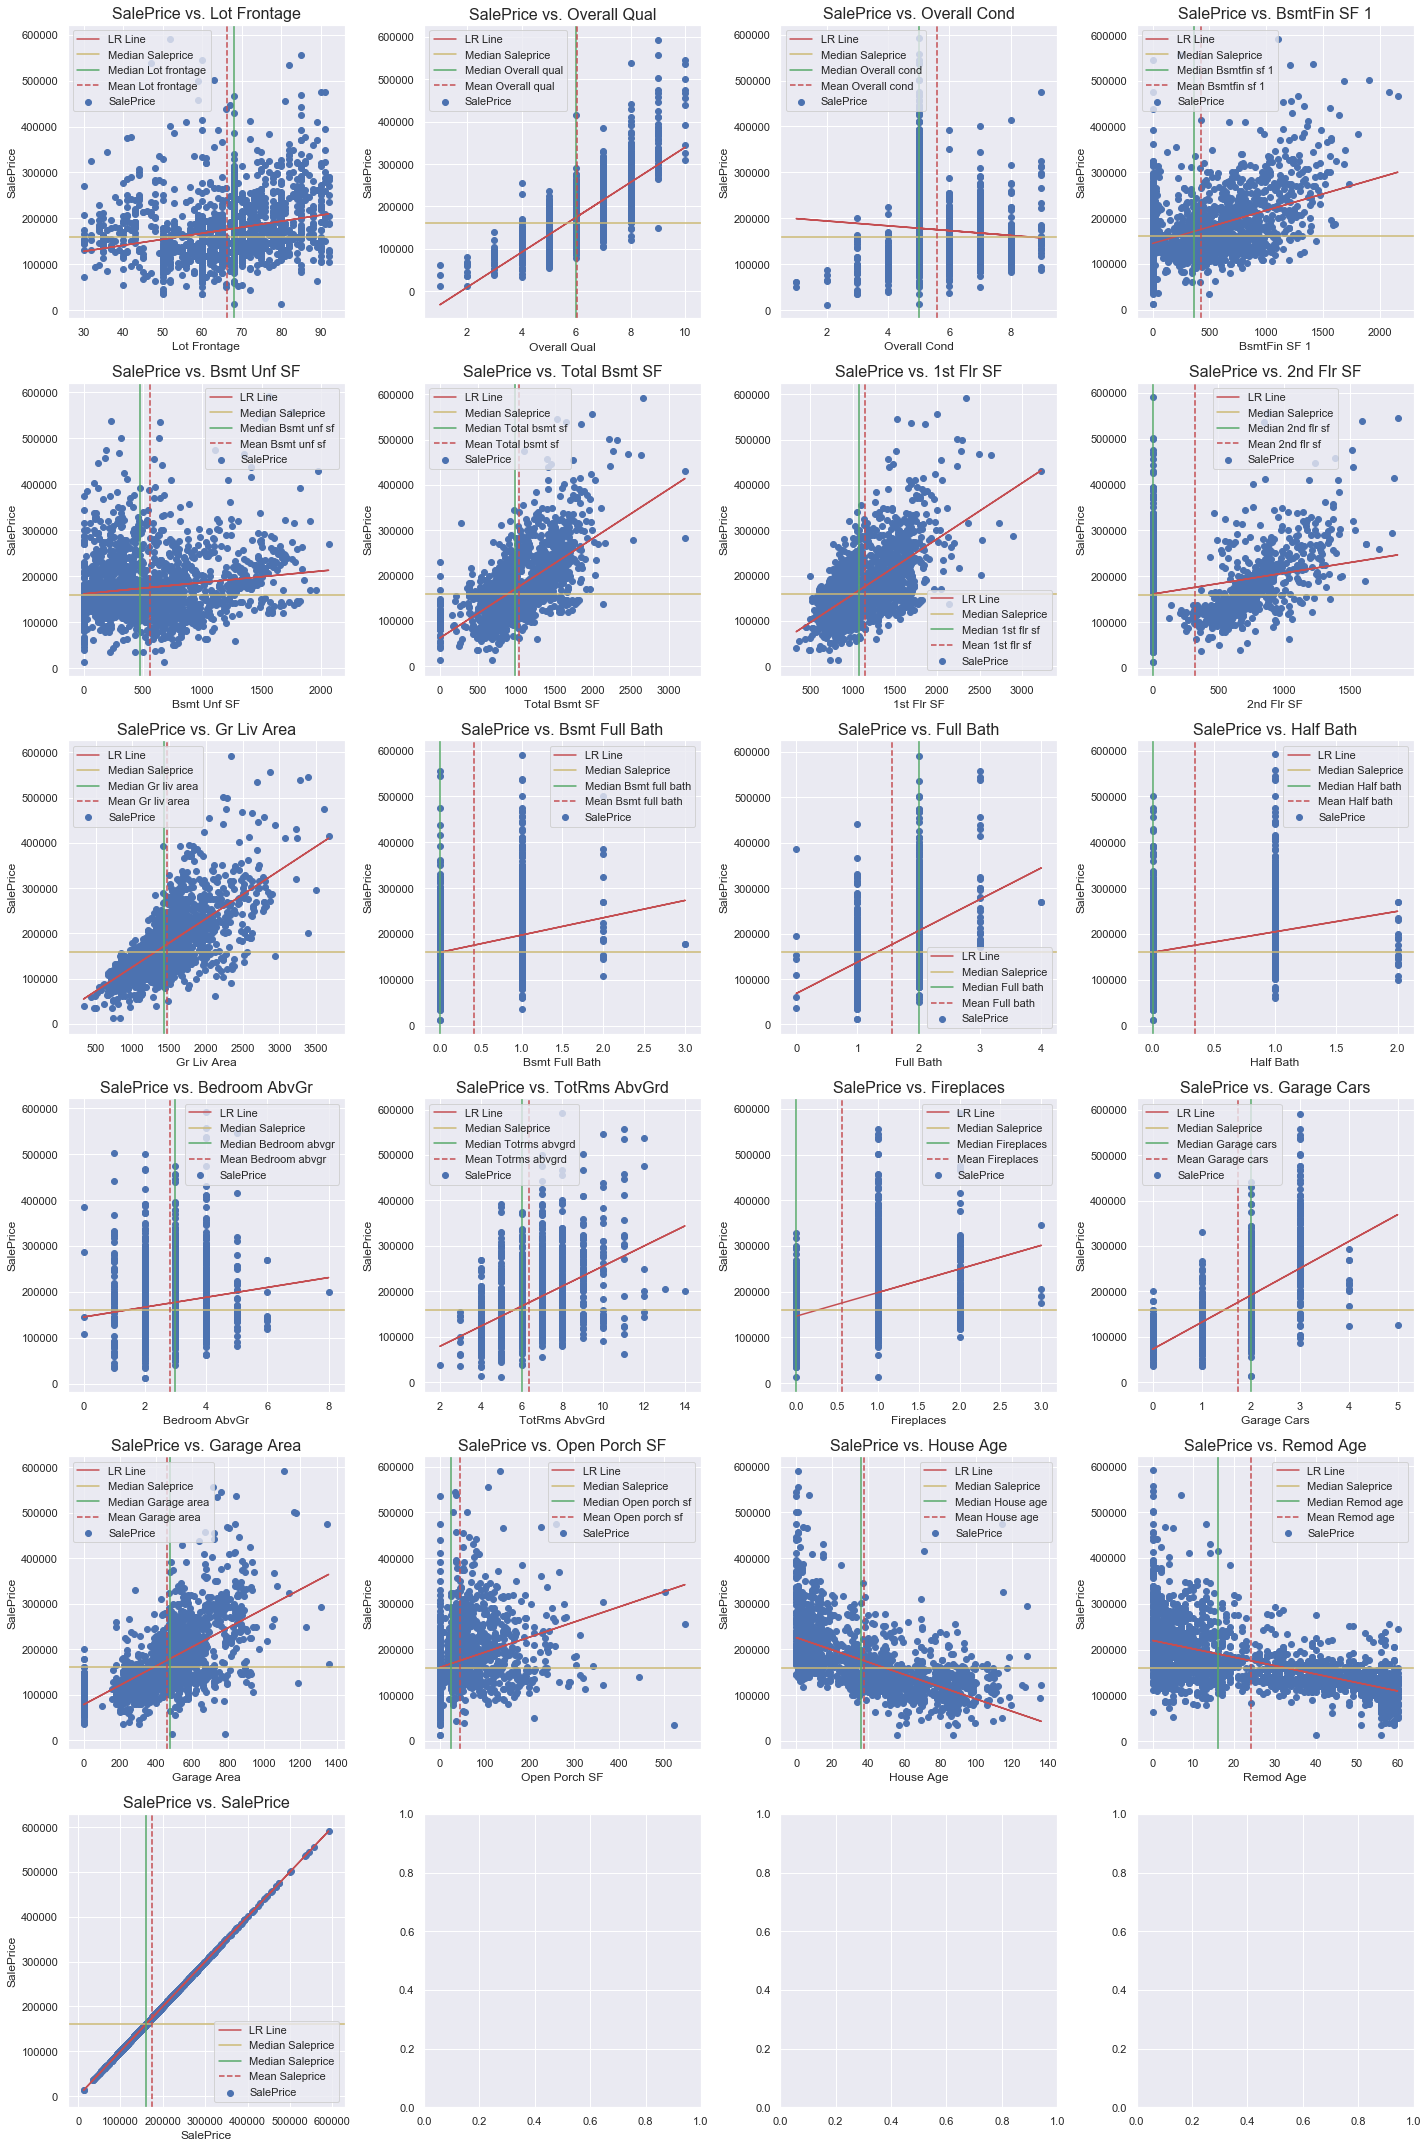

In [4355]:
subplot_num_scatter(train_num,list(train_num.columns),'SalePrice',(20,30),4)

In [4356]:
train_num_cols = list(train_num.columns)
train_num_drop = ['Lot Frontage','Overall Cond','BsmtFin SF 1','Bsmt Unf SF','2nd Flr SF','Bsmt Full Bath',
                 'Half Bath','Bedroom AbvGr'] #drop columns without a moderately strong linear relationship with SalePrice
train_num_keep = [i for i in train_num_cols if i not in train_num_drop]

In [4357]:
train = new_train.drop(train_num_drop,axis=1)
train_num = train.select_dtypes(exclude='O').drop('MS SubClass',axis=1)
test = test.drop(train_num_drop,axis=1)

#if columns in train are not being used, the same columns should not be used in test set

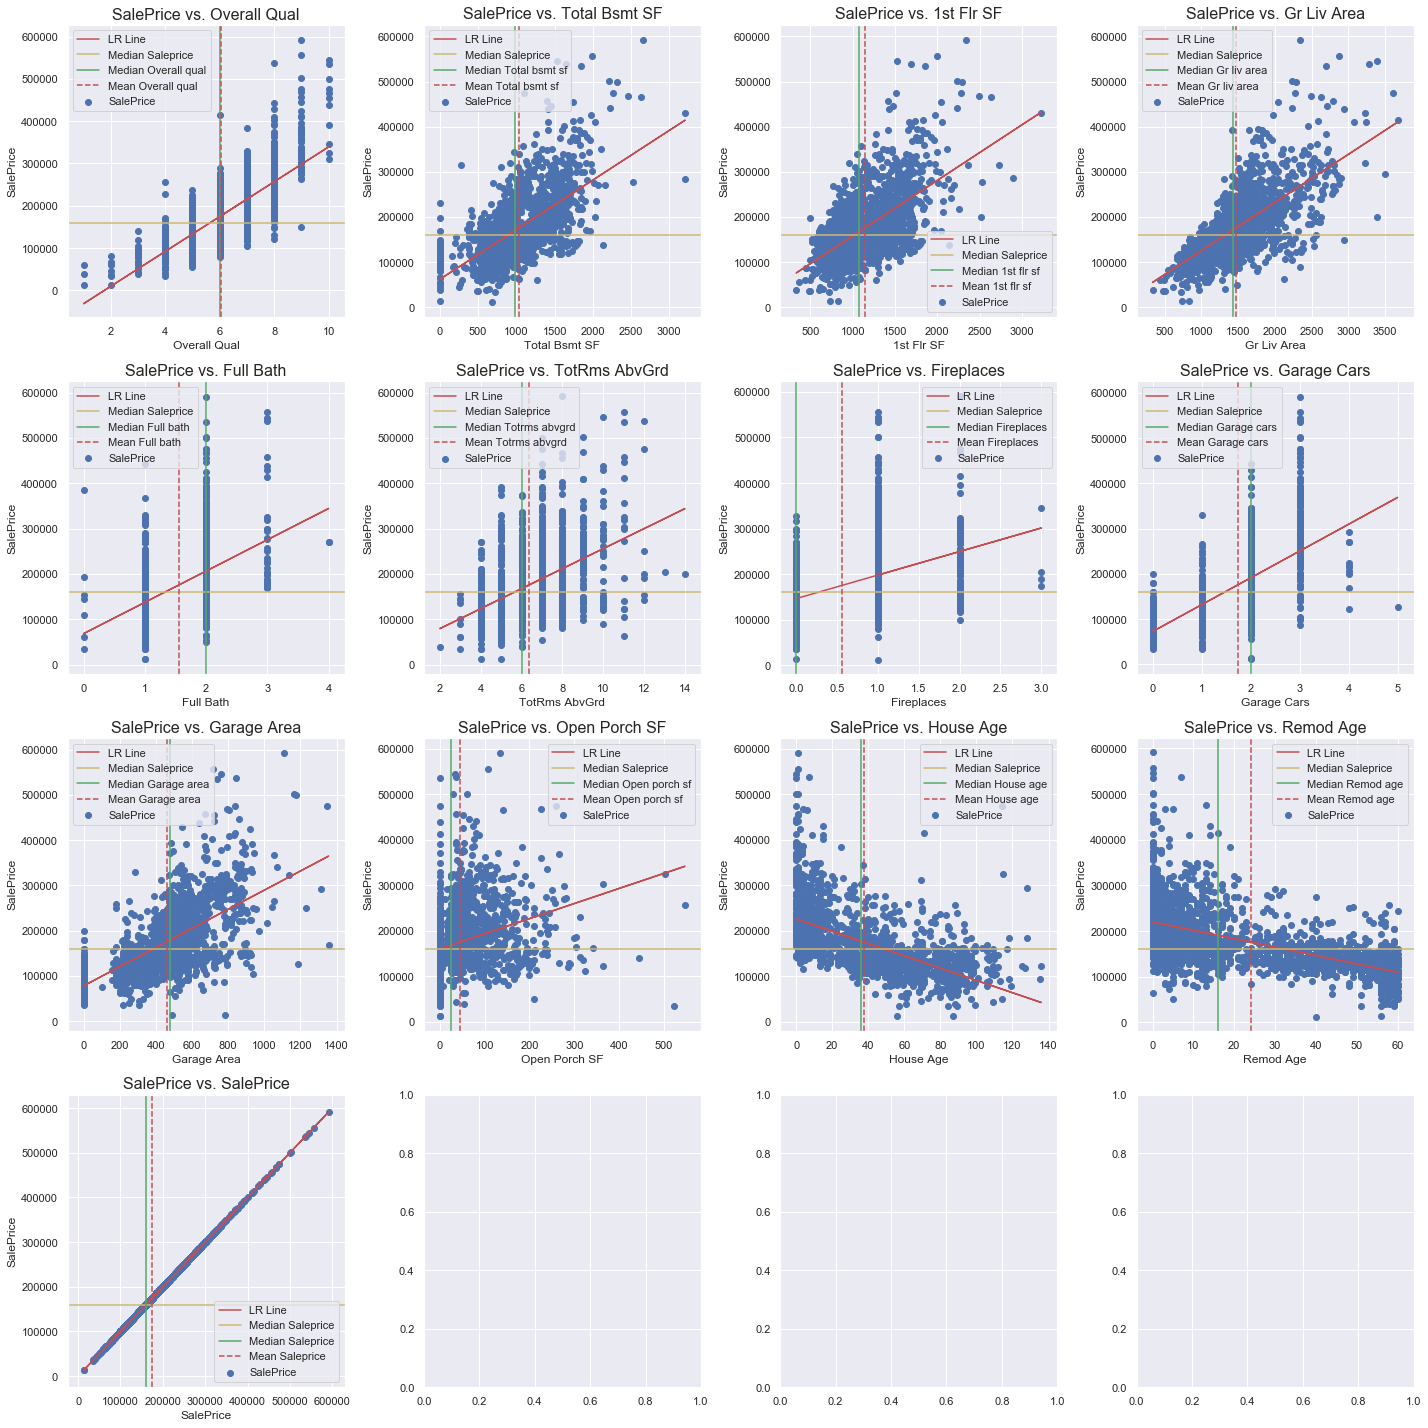

In [4358]:
subplot_num_scatter(train_num,list(train_num.columns),'SalePrice',(20,20),4)

## <span style = "color:green"> Feature Engineering: Ordinal Categorical Objects </span>

In [4359]:
train_unique_str = get_unique_obj_dict(train) #call the function again to update train_unique_str

ords = sorted(['Lot Shape', 'Utilities','Land Slope',
       # 'Overall Qual','Overall Cond',     Already included in numerical as integers ranging from 1 to 10
        'Exter Qual','Exter Cond',
        'Bsmt Qual','Bsmt Cond','Bsmt Exposure',
        'BsmtFin Type 1', 'BsmtFin Type 2',
        'Heating QC', 'Electrical','Kitchen Qual',
        'Functional', 'Fireplace Qu', 
        'Garage Finish','Garage Qual','Garage Cond', 'Paved Drive',
        'Pool QC','Fence'
       ])

noms = [i for i in train_unique_str if i not in ords]

In [4360]:
#Define order of ordinal columns' possible data entries

ords_dict = {}

ords_dict['Lot Shape'] = ['IR3','IR2','IR1','Reg']
ords_dict['Utilities'] = ['NoSeWa','NoSewr','AllPub']
ords_dict['Land Slope'] = ['Gtl','Mod','Sev']
ords_dict['Exter Qual'] = ['Po','Fa','TA','Gd','Ex']
ords_dict['Exter Cond'] = ['Po','Fa','TA','Gd','Ex']
ords_dict['Bsmt Qual'] = ['None','Po','Fa','TA','Gd','Ex']
ords_dict['Bsmt Cond'] = ['None','Po','Fa','TA','Gd','Ex']
ords_dict['Bsmt Exposure'] = ['None','No','Mn','Av','Gd']
ords_dict['BsmtFin Type 1'] = ['None', 'Unf', 'LwQ','Rec', 'BLQ', 'ALQ','GLQ']
ords_dict['BsmtFin Type 2'] = ['None', 'Unf', 'LwQ','Rec', 'BLQ', 'ALQ','GLQ']
ords_dict['Heating QC'] = ['Po','Fa','TA','Gd','Ex']
ords_dict['Electrical'] = ['Mix','FuseP','FuseF','FuseA','SBrkr']
ords_dict['Kitchen Qual'] = ['Po','Fa','TA','Gd','Ex']
ords_dict['Functional'] = ['Sal','Sev', 'Maj2','Maj1', 'Mod','Min2' , 'Min1','Typ']
ords_dict['Fireplace Qu'] = ['None','Po','Fa','TA','Gd','Ex']
ords_dict['Garage Finish'] = ['None','Unf','RFn','Fin']
ords_dict['Garage Qual'] = ['None','Po','Fa','TA','Gd','Ex']
ords_dict['Garage Cond'] = ['None','Po','Fa','TA','Gd','Ex']
ords_dict['Paved Drive'] = ['N','P','Y']
ords_dict['Pool QC'] = ['None','Fa','TA','Gd','Ex']
ords_dict['Fence'] = ['None','MnWw','GdWo','MnPrv','GdPrv']

#ords_dict

In [4361]:
train_ords = list(train.columns.intersection(ords))
train_ords

['Lot Shape',
 'Utilities',
 'Land Slope',
 'Exter Qual',
 'Exter Cond',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating QC',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Fireplace Qu',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC',
 'Fence']

In [4362]:
def subplot_ordcat(df, list_of_columns,fs=(15,15),cwrap=3):
    nrows = int(np.ceil(len(list_of_columns)/cwrap)) # Makes sure you have enough rows
                
    fig, ax= plt.subplots(nrows=nrows, ncols=cwrap,figsize=fs) # You'll want to specify your figsize
                
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ser = pd.Categorical(df[column],ords_dict[column],ordered=True).value_counts() #turns DF col categorical ordered series. Corresponds to ords_dict order
        ax[i].bar(ser.index,ser.values)
        ax[i].set_title('Counts for '+column,fontsize=16)
        ax[i].set_xlabel(column,fontsize=12)
        ax[i].set_ylabel('Count',fontsize=12)
        ax[i].axhline(y=0.8*len(df),color='g',label='Exclusion Threshold')
        ax[i].legend()
    plt.tight_layout()
    plt.show()

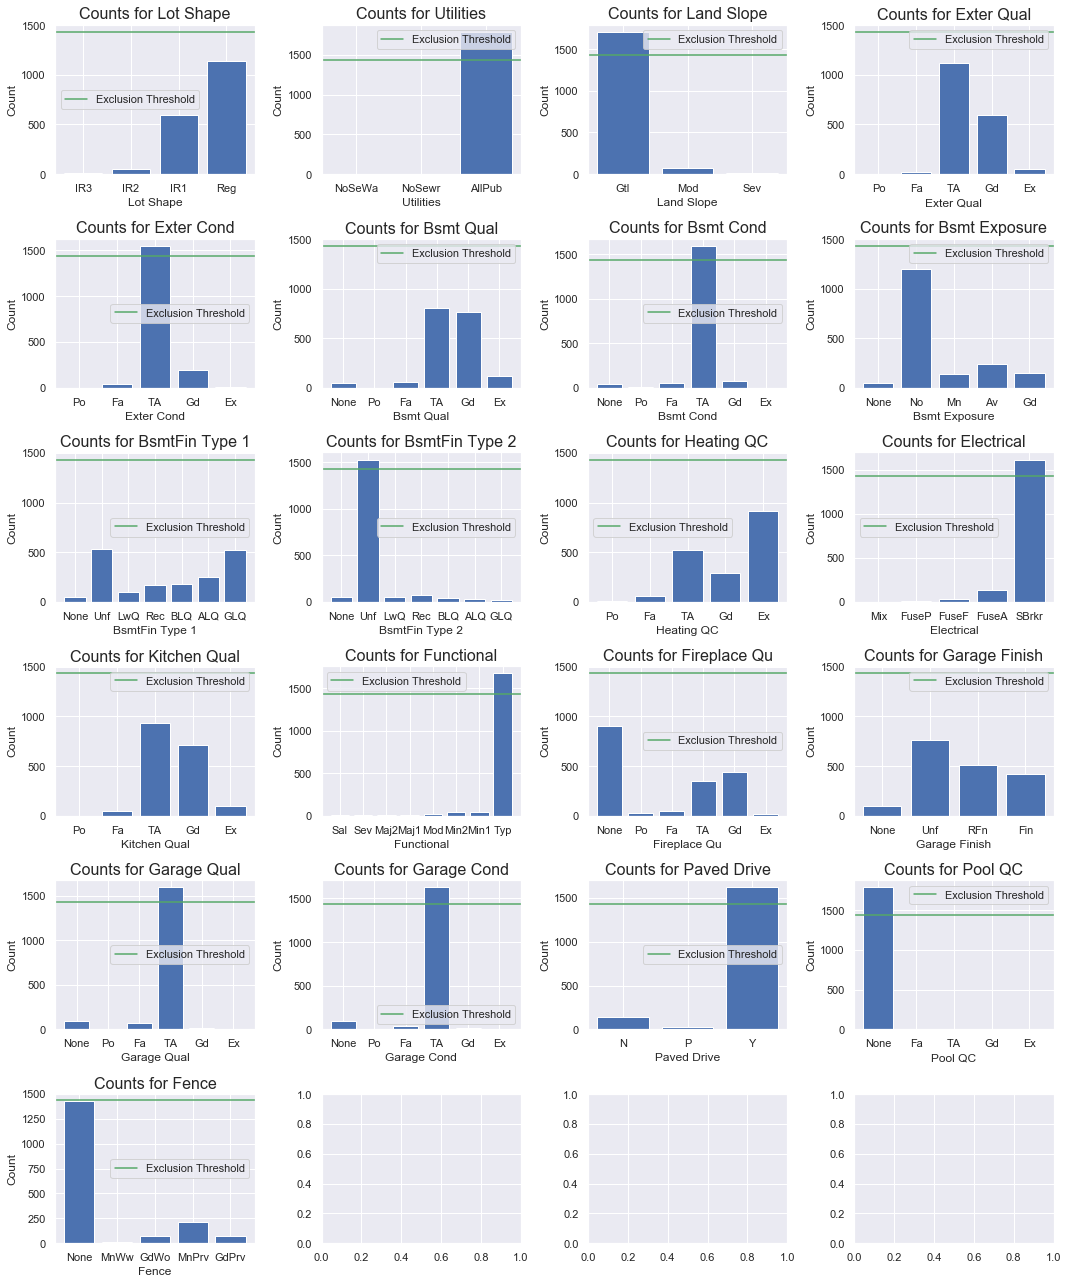

In [4363]:
subplot_ordcat(train,train_ords,(15,18),4)

According to the categorical plots above (ordered from lowest to highest grade from left to right), the following columns have very high counts for one category and very few for the others:

**Utilities, Land Slope, Exter Cond,Bsmt Cond,BsmtFin Type 2,Electrical,Functional,Garage Qual,Garage Cond, Paved Drive, Pool QC, Fence**

Because the modes for these features make up the large majority of data for their columns, it is unlikely that the non-modal data will have a large impact on the variability of the SalePrice.

These columns will be dropped from both testing and training datasets.

In [4364]:
long_str = 'Utilities, Land Slope, Exter Cond,Bsmt Cond,BsmtFin Type 2,Electrical,Functional,Garage Qual,Garage Cond, Paved Drive, Pool QC, Fence'
ord_drop_lst = [i.lstrip() for i in list(long_str.split(','))]

In [4365]:
train_ords = [i for i in train_ords if i not in ord_drop_lst]

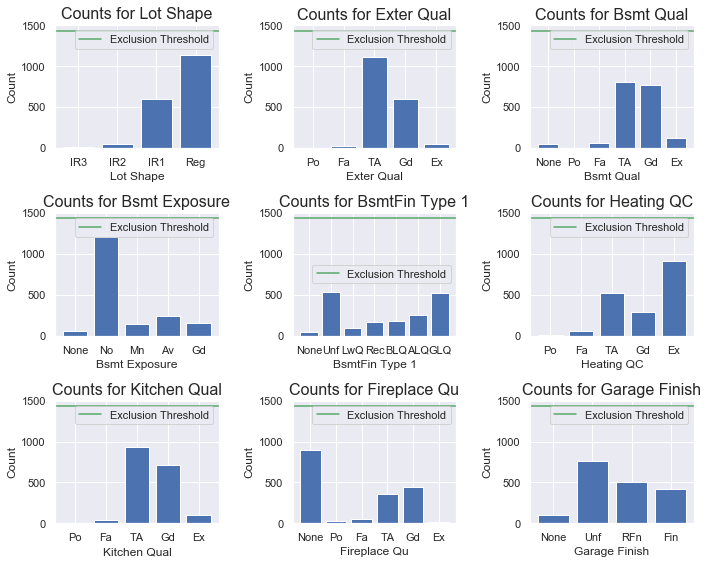

In [4366]:
subplot_ordcat(train,train_ords,(10,8),3)

In [4367]:
test_ords = list(test.columns.intersection(ords))

In [4368]:
test_ords = [i for i in test_ords if i not in ord_drop_lst]

In [4369]:
train.drop(columns=ord_drop_lst,inplace=True)

In [4370]:
train.columns.intersection(ord_drop_lst)

Index([], dtype='object')

In [4371]:
test.drop(columns=ord_drop_lst,inplace=True)
test.columns.intersection(ord_drop_lst)

Index([], dtype='object')

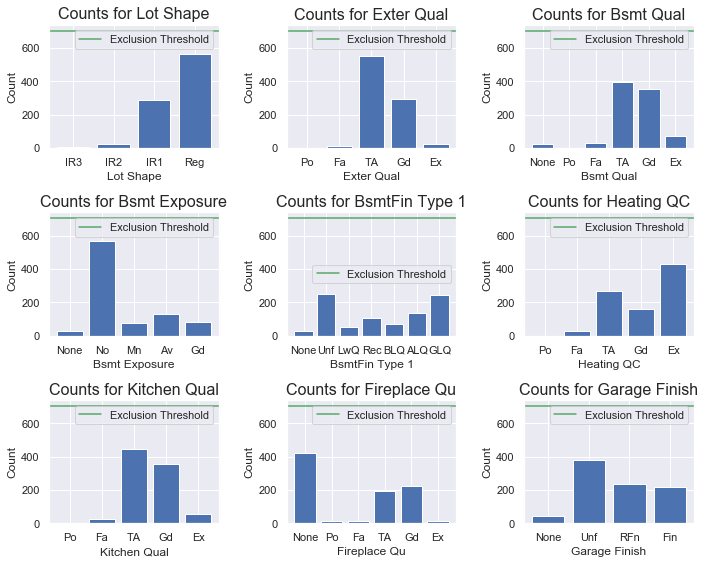

In [4372]:
subplot_ordcat(test,test_ords,(10,8),3)

These features seem reasonable to keep for both data sets because there is significant variation in the counts for each category.

In [4373]:
def subplot_cat_v_target(df,list_of_columns,target,fs=(15,15),cwrap=3):
    nrows = int(np.ceil(len(list_of_columns)/cwrap)) # Makes sure you have enough rows
                
    fig, ax= plt.subplots(nrows=nrows, ncols=cwrap,figsize=fs) # You'll want to specify your figsize
                
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ser = pd.Categorical(df[column],ords_dict[column],ordered=True).value_counts()
        sns.stripplot(x=column,y=target,data=train, order=ser.index, ax =ax[i])
        ax[i].set_title(target+" vs. "+column,fontsize=16)
        ax[i].axhline(y=df[target].median(),color='y',label='Median '+(target).capitalize())
        # For future improvement: Add in a line that plots the median saleprices for all categories
        ax[i].legend()
    plt.tight_layout()
    plt.show()

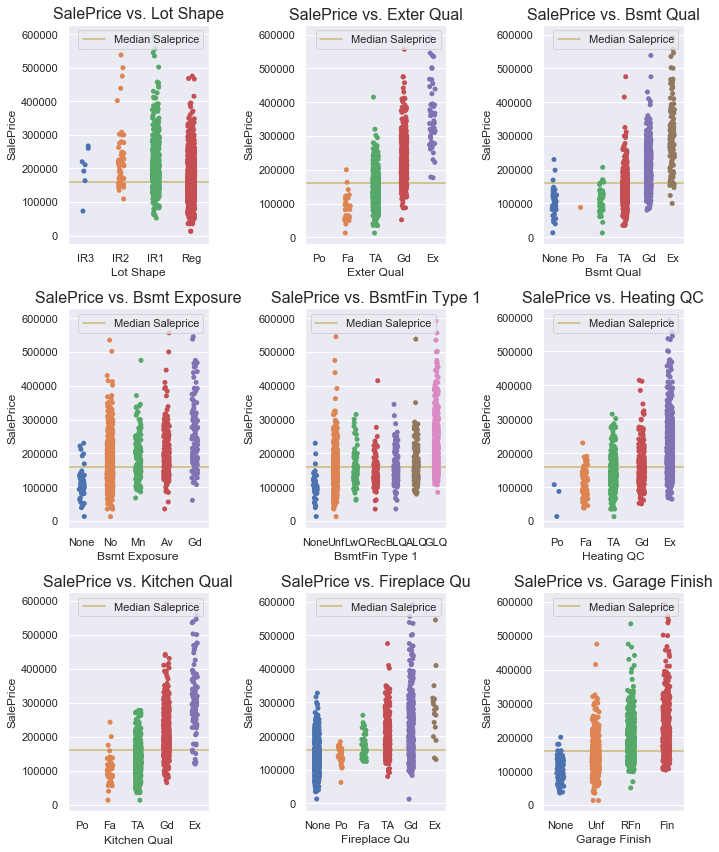

In [4374]:
subplot_cat_v_target(train,train_ords,target='SalePrice',fs=(10,12))
#Plots for Ordinal Categorical data. Increasing value/importance from left to right.
#Plotting is done only for training set because test set has no SalePrice data.

## Ordinal Variables with the most impact
The ordinal categorical variables that seem to have the strongest effect on SalePrice are: 
- Exter Qual
- Bsmt Qual
- Kitchen Qual
- Fireplace Qu
- Garage Finish.

As the quality of each feature increases, so does the SalePrice.

Of these factors, Exter Qual, Kitchen Qual, Fireplace Qu, and Garage Finish seem to have the most impact.

In [4375]:
fin_ords = ['Exter Qual','Bsmt Qual','Kitchen Qual','Fireplace Qu','Garage Finish']
#final ordinals will be used on both data sets.
train_ords = list(train.columns.intersection(ords))

final_ord_drop_lst = [i for i in train_ords if i not in fin_ords]  # drop columns that are not likely to account for variability in SalePrice
train.drop(columns=final_ord_drop_lst,inplace=True)
train.columns.intersection(final_ord_drop_lst)    #Check for empty index to be sure that training set no longer has undesired columns

fin_train_ords = list(train.columns.intersection(ords)) #get new list of ordinal columns for future use
fin_train_noms = list(train.select_dtypes(include='O').columns.difference(ords))

In [4376]:
test_ords = list(test.columns.intersection(ords))

final_ord_drop_lst = [i for i in test_ords if i not in fin_ords]  # drop columns that are not likely to account for variability in SalePrice
test.drop(columns=final_ord_drop_lst,inplace=True)
test.columns.intersection(final_ord_drop_lst)    #Check for empty index to be sure that test set no longer has undesired columns

fin_test_ords = list(test.columns.intersection(ords))
fin_test_noms = list(test.select_dtypes(include='O').columns.difference(ords))

## Mapping Ordinals to Numbers

In [4377]:
def ords_to_num(df,ord_cols_list):
    df_num_ords = df[ord_cols_list]
        
    for row, col in enumerate(df_num_ords):
        df_num_ords.loc[:,col] = df_num_ords[col].astype(pd.api.types.CategoricalDtype(categories=ords_dict[col])).cat.codes

    return df_num_ords

In [4378]:
fin_train_num_ords = ords_to_num(train,fin_train_ords)
fin_train_num_ords.head()

C:\Users\kapit\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\kapit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Exter Qual,Bsmt Qual,Kitchen Qual,Fireplace Qu,Garage Finish
0,3,3,3,0,2
1,3,4,3,3,2
2,2,3,3,0,1
3,2,4,2,0,3
4,2,2,2,0,1


In [4379]:
fin_test_num_ords = ords_to_num(test,fin_test_ords)
fin_test_num_ords.head()

,Exter Qual,Bsmt Qual,Kitchen Qual,Fireplace Qu,Garage Finish
0,2,2,1,0,1
1,2,4,2,0,3
2,3,4,3,4,2
3,3,3,2,0,1
4,2,4,2,4,2


In [4380]:
for i in fin_train_ords:
    #print(i)
    train[i]=fin_train_num_ords[i]    #replace training set ordinal categorical data with ordinal numbers

train[fin_train_ords].head()

,Exter Qual,Bsmt Qual,Kitchen Qual,Fireplace Qu,Garage Finish
0,3,3,3,0,2
1,3,4,3,3,2
2,2,3,3,0,1
3,2,4,2,0,3
4,2,2,2,0,1


In [4381]:
for i in fin_test_ords:
    #print(i)
    test[i]=fin_test_num_ords[i]    #replace training set ordinal categorical data with ordinal numbers

test[fin_test_ords].head()

,Exter Qual,Bsmt Qual,Kitchen Qual,Fireplace Qu,Garage Finish
0,2,2,1,0,1
1,2,4,2,0,3
2,3,4,3,4,2
3,3,3,2,0,1
4,2,4,2,4,2


In [4382]:
train.to_csv('datasets/train_cleaned_ords-done_no-dum.csv')
test.to_csv('datasets/test_cleaned_ords-done_no-dum.csv')

In [4383]:

train.drop('SalePrice',axis=1,inplace=True)

In [4384]:
train['MS SubClass']=pd.Categorical(train['MS SubClass'])
test['MS SubClass']=pd.Categorical(test['MS SubClass'])

In [4385]:
def subplot_nomcat(df, list_of_columns,fs=(15,15),cwrap=3,threshold=0.8):
    
    final_list_of_columns=[]
    for i, column in enumerate(list_of_columns):
        if max(df[column].value_counts())/len(df) < threshold:
            final_list_of_columns.append(column)                  #shortlists only columns that pass the threshold for exclusion
    
    nrows = int(np.ceil(len(final_list_of_columns)/cwrap)) # Makes sure you have enough rows
                
    fig, ax= plt.subplots(nrows=nrows, ncols=cwrap,figsize=fs) # You'll want to specify your figsize
                
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate    

    for j, col in enumerate(final_list_of_columns): # Gives us an index value to get into all our lists
        ser = pd.Categorical(df[col]).value_counts()
        ax[j].bar(ser.index,ser.values)
        ax[j].set_title('Counts for '+col,fontsize=16)
        ax[j].set_xlabel(col,fontsize=12)
        ax[j].set_ylabel('Count',fontsize=12)
        ax[j].axhline(y=threshold*len(df),color='g',label='Exclusion Threshold')
        ax[j].legend()

    plt.tight_layout()
    plt.show()
    
    return final_list_of_columns

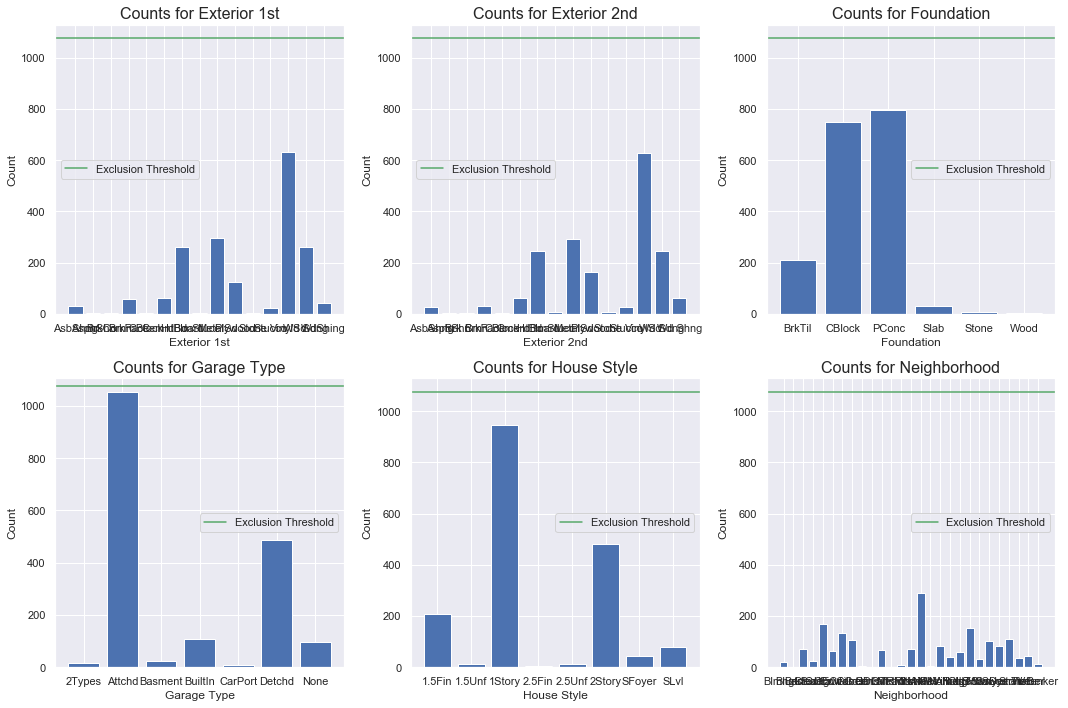

['Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Garage Type',
 'House Style',
 'Neighborhood']

In [4386]:
subplot_nomcat(train,fin_train_noms,(15,10),threshold=0.6)

In [4387]:
cat_nom_keep = ['Exterior 1st','Foundation','Garage Type','Neighborhood'] 

#dropped Roof Style and MS Zoning. Introducing slight bias in favour of a simpler model
#Exterior 1st and 2nd are highly similar
#House Style and MS SubClass are highly similar

cat_nom_drop = [i for i in noms if i not in cat_nom_keep]

In [4388]:
train = train.drop(cat_nom_drop,axis=1)
test = test.drop(cat_nom_drop,axis=1)

In [4389]:
print(train.shape)
print(test.shape)

(1792, 22)
(879, 22)


In [4390]:
train.head()

,MS SubClass,Neighborhood,Overall Qual,Exterior 1st,Exter Qual,Foundation,Bsmt Qual,Total Bsmt SF,1st Flr SF,Gr Liv Area,...,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Type,Garage Finish,Garage Cars,Garage Area,Open Porch SF,House Age,Remod Age
0,60,Sawyer,6.00000,HdBoard,3,CBlock,3,725.00000,725.00000,1479.00000,...,6.00000,0.00000,0,Attchd,2,2.00000,475.00000,44.00000,34.00000,5.00000
1,60,SawyerW,7.00000,VinylSd,3,PConc,4,913.00000,913.00000,2122.00000,...,8.00000,1.00000,3,Attchd,2,2.00000,559.00000,74.00000,13.00000,12.00000
2,20,NAmes,5.00000,VinylSd,2,CBlock,3,1057.00000,1057.00000,1057.00000,...,5.00000,0.00000,0,Detchd,1,1.00000,246.00000,52.00000,57.00000,3.00000
3,60,Timber,5.00000,VinylSd,2,PConc,4,384.00000,744.00000,1444.00000,...,7.00000,0.00000,0,BuiltIn,3,2.00000,400.00000,0.00000,4.00000,3.00000
4,50,SawyerW,6.00000,Wd Sdng,2,PConc,2,676.00000,831.00000,1445.00000,...,6.00000,0.00000,0,Detchd,1,2.00000,484.00000,59.00000,110.00000,17.00000


77 features reduced to 22 manually.

## Scaling train and test data sets

In [4686]:
#combine both dataframes to get dummies, then split them cleanly -- save time on checking columns
comb_df_clean = pd.concat([train,test])
comb_df_clean['MS SubClass'] = pd.Categorical(comb_df_clean['MS SubClass'].apply(str))
comb_df_clean_w_dum = pd.get_dummies(comb_df_clean,drop_first=True)
train_clean_w_dum = comb_df_clean_w_dum.iloc[:len(train),:].reset_index(drop=True)
test_clean_w_dum = comb_df_clean_w_dum.iloc[-len(test):,:].reset_index(drop=True)

In [4687]:
#Function for checking column equivalence
def check_cols(df1,df2):
    cols_1 = list(df1.columns)
    cols_2 = list(df2.columns)

    if len(cols_1) > len(cols_2):
        col_diff = [i for i in cols_1 if i not in cols_2]
        ret_dict = {'Missing in df2':col_diff}

        return ret_dict        #return dictionary with df name and column where mismatching value is detected
        
                      
    elif len(cols_2) > len(cols_1):
        col_diff = [i for i in cols_2 if i not in cols_1]
        ret_dict = {'Missing in df1':col_diff}
        return ret_dict        #return dictionary with df name and column where mismatching value is detected
    
    else:
        print("Column counts match!")

In [4688]:
check_dict = check_cols(train_clean_w_dum,test_clean_w_dum)
check_dict

Column counts match!


In [4689]:
#one final check on the columns after rearrangement
list(train_clean_w_dum.columns) == list(test_clean_w_dum.columns)

True

In [4690]:
train_clean_w_dum.to_csv('datasets/train_cleaned_ords-done_w-dum.csv')
test_clean_w_dum.to_csv('datasets/test_cleaned_ords-done_w-dum.csv')

In [4691]:
scaler = StandardScaler()

In [4692]:
scaled_train = scaler.fit_transform(train_clean_w_dum)
scaled_test = scaler.fit_transform(test_clean_w_dum)

C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int8, uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int8, uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int8, uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int8, uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [4693]:
scaled_train_df = pd.DataFrame(scaled_train,columns=list(train_clean_w_dum.columns))
scaled_test_df = pd.DataFrame(scaled_test,columns=list(test_clean_w_dum.columns))

In [4694]:
scaled_train_df['SalePrice']=y.reset_index(drop=True)
#re-insert non-scaled target variable

In [4695]:
s_train_df_corr = scaled_train_df.corr().fillna(0.0)
#NaNs generated in corr matrix from columns that have only 0s.
#Such correlation values interpreted as 0.

In [4696]:
pd.DataFrame(s_train_df_corr.unstack().sort_values(ascending=False).drop_duplicates().head(15))

,,0
SalePrice,SalePrice,1.00000
Garage Cars,Garage Area,0.89029
Fireplaces,Fireplace Qu,0.87202
Overall Qual,SalePrice,0.79602
Gr Liv Area,TotRms AbvGrd,0.79538
1st Flr SF,Total Bsmt SF,0.79268
Overall Qual,Exter Qual,0.71889
Exter Qual,Kitchen Qual,0.70684
SalePrice,Gr Liv Area,0.70068
Exter Qual,SalePrice,0.69301


## Cleaning: Highly correlated features

The following features have high correlation to each other and should be removed:

|Feature 1 |Feature 2| Removed Feature|Reasoning|
|------|-----|-----|-----|
|Garage Area|Garage Cars| Garage Cars | Big garage can fit many cars. No garage, no car. The converse is not necessarily true.|
|Fireplace Qu| Fireplaces| Fireplace Qu | Number of fireplaces is more significant since it can be assumed that houses with more fireplaces tend to have high quality ones. |
|Overall Qual | Exter Qual | Exter Qual | Multi-collinearity|
|Gr Liv Area | TotRms AbvGrd | TotRms AbvGrd| Multi-collinearity|
|Total Bsmt SF| 1st Flr SF| Total Bsmt SF | Multi-collinearity|
|Kitchen Qual| Overall Qual | Kitchen Qual |Overall Qual covers a broader spectrum|
|Gr Liv Area | Full Bath | Full Bath |Gr Liv Area retained above|
|Overall Qual| Bsmt Qual| Bsmt Qual | Overall Qual covers a broader spectrum|

In [4697]:
drop_cols = ['Exter Qual','Garage Cars','Fireplace Qu','TotRms AbvGrd','Total Bsmt SF','Kitchen Qual','Full Bath','Bsmt Qual']
semifin_cols = [i for i in list(scaled_train_df.columns) if i not in drop_cols]
semifin_train = scaled_train_df[semifin_cols]
semifin_cols.remove('SalePrice')
semifin_test = scaled_test_df[semifin_cols]

In [4698]:
s_train_df_corr = semifin_train.corr().fillna(0.0)

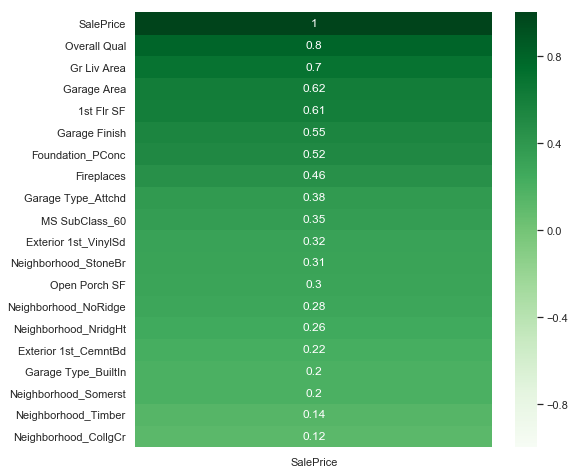

In [4699]:
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(s_train_df_corr[['SalePrice']].sort_values('SalePrice').tail(20),    
            vmax=1, vmin=-1, center=0, cmap='Greens', annot=True, ax=ax);
g.invert_yaxis()

In [4700]:
top_20_corr = list(s_train_df_corr[['SalePrice']].sort_values('SalePrice').tail(20).index)
top_20_corr = top_20_corr[::-1]

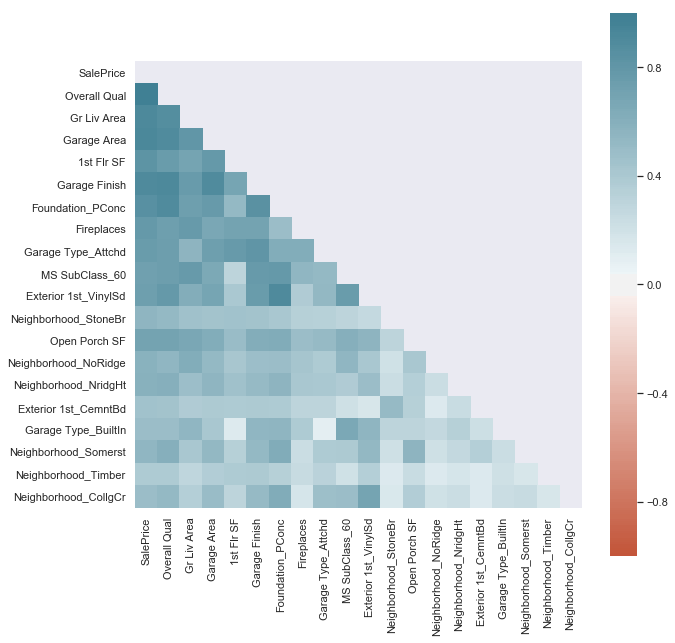

In [4701]:
fig = plt.figure(figsize=(10,10))
s_train_corr = s_train_df_corr[top_20_corr].corr()

mask = np.zeros_like(s_train_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(s_train_corr, mask=mask, vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

In [4702]:
drop_cols = ['Garage Finish','Exterior 1st_VinylSd','Garage Type_BuiltIn']
semifin_train = semifin_train.drop(drop_cols,axis=1)
semifin_test = semifin_test.drop(drop_cols,axis=1)

# <span style = "color:green">Cross-Validation of Training Data</span>

In [4703]:
semifin_cols = list(semifin_train.columns)
semifin_cols.remove('SalePrice')
X = semifin_train[semifin_cols]
y = semifin_train['SalePrice']

## Baseline: Linear Regression model

Creating a linear regression model to obtain baseline performance given presently selected features.

In [4704]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337)

In [4705]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [4706]:
kf = KFold(n_splits=5, random_state=1337, shuffle=True)

In [4707]:
OLS_baseline_Rsq = cross_val_score(lr,X_train,y_train,cv=kf).mean()

In [4708]:
OLS_baseline_RMSE = np.sqrt(abs(cross_val_score(lr,X_train,y_train,scoring='neg_mean_squared_error',cv=kf).mean()))

Linear regression produces a very overfitted model.

## Cross-Validation with LassoCV and RidgeCV

### LassoCV

In [4709]:
lassoregcv = LassoCV(n_alphas=100,random_state=1337)
lassoregcv.fit(X_train,y_train)
best_lasso_alpha = lassoregcv.alpha_
best_lasso_alpha

C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


80.43636802691255

In [4710]:
base_lassocv_Rsq=cross_val_score(lassoregcv,X_train,y_train,cv=kf).mean()
base_lassocv_RMSE=np.sqrt(abs(cross_val_score(lassoregcv,X_train,y_train,scoring='neg_mean_squared_error',cv=kf).mean()))

C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

In [4711]:
print(base_lassocv_Rsq)
print(base_lassocv_RMSE)

0.8493432129822811
27397.046208786374


### RidgeCV

In [4712]:
ridgereg_cv = RidgeCV(list(np.arange(0.1,200,0.1)))
model_cv = ridgereg_cv.fit(X_train,y_train)

In [4713]:
best_ridge_alpha = model_cv.alpha_
best_ridge_alpha

15.8

In [4714]:
base_ridgecv_Rsq = cross_val_score(ridgereg_cv,X_train,y_train,cv=kf).mean()
base_ridgecv_RMSE = np.sqrt(abs(cross_val_score(ridgereg_cv,X_train,y_train,scoring='neg_mean_squared_error',cv=kf).mean()))

In [4715]:
print(base_ridgecv_Rsq)
print(base_ridgecv_RMSE)

0.8499198188780109
27343.109566213505


Based on Cross Validation Scores, Ridge Regression should provide the best R-squared of all 3 models with an alpha of 13.1.

# <span style="color:green"> Modelling - Pre-RFE </span>

### Ridge Regression Pre-RFE

In [4716]:
ridgereg = Ridge(alpha=best_ridge_alpha)

ridgereg.fit(X, y)

y_pred = ridgereg.predict(X)

ridge_pre_RMSE = np.sqrt(mean_squared_error(y, y_pred))

ridge_pre_Rsq = r2_score(y,y_pred)

print("RMSE:",ridge_pre_RMSE)

print("R-squared:",ridge_pre_Rsq)

RMSE: 25819.124114152542
R-squared: 0.8659741827785664


### Lasso Regression Pre-RFE

In [4717]:
lassoreg = Lasso(alpha=best_lasso_alpha, random_state=1337, max_iter=10000)

lassoreg.fit(X, y)

y_pred = lassoreg.predict(X)

lasso_pre_RMSE = np.sqrt(mean_squared_error(y, y_pred))

lasso_pre_Rsq = r2_score(y,y_pred)

print("RMSE:",lasso_pre_RMSE)

print("R-squared:",lasso_pre_Rsq)

RMSE: 25840.14079078735
R-squared: 0.8657559008823863


# Modelling - RFE

### Recursive Feature Elimination

In [4718]:
rfe = RFE(estimator=lr,n_features_to_select=15)
rfe.fit(X,y)
rfe.transform(X)

array([[-0.02213098, -1.20242821,  0.02462739, ..., -0.18772252,
        -0.14318219, -0.24052285],
       [ 0.71228958, -0.66184762,  1.40941446, ..., -0.18772252,
        -0.14318219, -0.24052285],
       [-0.75655153, -0.24778589, -0.88420643, ..., -0.18772252,
        -0.14318219, -0.24052285],
       ...,
       [-0.02213098,  0.0828884 ,  0.95930482, ..., -0.18772252,
        -0.14318219, -0.24052285],
       [-1.49097209,  0.16340041, -0.57623667, ..., -0.18772252,
        -0.14318219, -0.24052285],
       [ 0.71228958, -0.33117332,  0.72455864, ..., -0.18772252,
        -0.14318219, -0.24052285]])

In [4719]:
rfe_mask = rfe.support_
rem_features = X.columns[rfe_mask]
rem_features = list(rem_features)

### Final Iteration

In [4720]:
final_X = semifin_train[rem_features]

In [4721]:
X_train, X_test, y_train, y_test = train_test_split(final_X, y, random_state=1337)

In [4722]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [4723]:
kf = KFold(n_splits=10, random_state=1337, shuffle=True)

In [4724]:
fin_OLS_Rsq = cross_val_score(lr,X_train,y_train,cv=kf).mean()
fin_OLS_RMSE = np.sqrt(abs(cross_val_score(lr,X_train,y_train,scoring='neg_mean_squared_error',cv=kf).mean()))

### LassoCV

In [4725]:
lassoregcv = LassoCV(n_alphas=100,random_state=1337)
lassoregcv.fit(X_train,y_train)
best_lasso_alpha = lassoregcv.alpha_
best_lasso_alpha

C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


56.746267502207765

In [4726]:
fin_lassocv_Rsq = cross_val_score(lassoregcv,X_train,y_train,cv=kf).mean()
fin_lassocv_RMSE = np.sqrt(abs(cross_val_score(lassoregcv,X_train,y_train,scoring='neg_mean_squared_error',cv=kf).mean()))

C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\kapit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

### RidgeCV

In [4727]:
ridgereg_cv = RidgeCV(list(np.arange(0.1,200,0.1)))
model_cv = ridgereg_cv.fit(X_train,y_train)

In [4728]:
best_ridge_alpha = model_cv.alpha_
best_ridge_alpha

34.900000000000006

In [4729]:
fin_ridgecv_Rsq = cross_val_score(ridgereg_cv,X_train,y_train,cv=kf).mean()
fin_ridgecv_RMSE = np.sqrt(abs(cross_val_score(ridgereg_cv,X_train,y_train,scoring='neg_mean_squared_error',cv=kf).mean()))

# <span style="color:green"> Modelling - After RFE </span>

### Ridge Regression Post-RFE

In [4730]:
ridgereg = Ridge(alpha=best_ridge_alpha)

ridgereg.fit(X_train, y_train)

y_pred = ridgereg.predict(final_X)

fin_post_ridge_RMSE = np.sqrt(mean_squared_error(y, y_pred))

fin_post_ridge_Rsq = r2_score(y,y_pred)

print("RMSE:",fin_post_ridge_RMSE)

print("R-squared:",fin_post_ridge_Rsq)

RMSE: 27877.48766319068
R-squared: 0.8437526291813042


### Lasso Regression Post-RFE

In [4731]:
lassoreg = Lasso(alpha=best_lasso_alpha, random_state=1337, max_iter=10000)

lassoreg.fit(X_train, y_train)

y_pred = lassoreg.predict(final_X)

fin_post_lasso_RMSE = np.sqrt(mean_squared_error(y, y_pred))

fin_post_lasso_Rsq = r2_score(y,y_pred)

print("RMSE:",fin_post_lasso_RMSE)

print("R-squared:",fin_post_lasso_Rsq)

RMSE: 27869.303526639444
R-squared: 0.843844356393558


# Submission

In [4732]:
subs_test = pd.read_csv('./datasets/test.csv')['Id']

In [4733]:
subs_x = semifin_test[list(rem_features)]

In [4734]:
subs_pred = lassoreg.predict(subs_x)

In [4735]:
subs_x['SalePrice'] = subs_pred.astype(int)
subs_x.insert(loc=0,column='ID',value=subs_test)

C:\Users\kapit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [4736]:
sub_df = subs_x[['ID','SalePrice']]
sub_df.to_csv('./datasets/sub_predictions.csv')

In [4737]:
pre_feats=len(semifin_train.columns)

In [4738]:
post_feats=len(final_X.columns)

# <span style ="color:green"> Summary </span>

In [4739]:
score_df = pd.DataFrame({'Features':[pre_feats,pre_feats,pre_feats,
                                     pre_feats,pre_feats,
                                     post_feats,post_feats,post_feats,
                                     post_feats,post_feats],
                         'R-squared':[OLS_baseline_Rsq,base_lassocv_Rsq,base_ridgecv_Rsq,
                                      ridge_pre_Rsq,lasso_pre_Rsq,
                                      fin_OLS_Rsq,fin_lassocv_Rsq,fin_ridgecv_Rsq,
                                      fin_post_ridge_Rsq,fin_post_lasso_Rsq],
                         'RMSE':[OLS_baseline_RMSE,base_lassocv_MSE,base_ridgecv_RMSE,
                                 ridge_pre_RMSE,lasso_pre_RMSE,
                                 fin_OLS_RMSE,fin_lassocv_RMSE,fin_ridgecv_RMSE,
                                 fin_post_ridge_RMSE,fin_post_lasso_RMSE]},
                        index=['OLS Baseline','LassoCV Baseline','RidgeCV Baseline',
                                 'Ridge Pre-RFE','Lasso Pre-RFE',
                                 'OLS Baseline Post-RFE','LassoCV Baseline Post-RFE','RidgeCV Baseline Post-RFE',
                                 'Ridge Post-RFE','Lasso Post-RFE'])

In [4740]:
pd.options.display.float_format = '{:.5f}'.format

In [4742]:
score_df

,Features,R-squared,RMSE
OLS Baseline,75,-1497787013710829232062464....,84593790781937488.00000
LassoCV Baseline,75,0.84934,26956.10623
RidgeCV Baseline,75,0.84992,27343.10957
Ridge Pre-RFE,75,0.86597,25819.12411
Lasso Pre-RFE,75,0.86576,25840.14079
OLS Baseline Post-RFE,15,0.83226,28512.95084
LassoCV Baseline Post-RFE,15,0.83227,28513.48311
RidgeCV Baseline Post-RFE,15,0.83258,28497.40352
Ridge Post-RFE,15,0.84375,27877.48766
Lasso Post-RFE,15,0.84384,27869.30353


In [4745]:
print(list(rem_features))

['Overall Qual', '1st Flr SF', 'Gr Liv Area', 'Fireplaces', 'Garage Area', 'House Age', 'Remod Age', 'MS SubClass_20', 'MS SubClass_60', 'Neighborhood_Crawfor', 'Neighborhood_GrnHill', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'Garage Type_None']


In [4751]:
nbh_train = new_train.reset_index(drop=True)

In [4757]:
nbh_train.groupby(['Neighborhood'])['SalePrice'].median()

Neighborhood
Blmngtn   192250.00000
Blueste   173750.00000
BrkSide   128000.00000
ClearCr   227500.00000
CollgCr   200000.00000
Crawfor   199500.00000
Edwards   122000.00000
Gilbert   181755.00000
Greens    190000.00000
GrnHill   280000.00000
IDOTRR    102388.00000
Landmrk   137000.00000
MeadowV   127000.00000
Mitchel   160250.00000
NAmes     140000.00000
NPkVill   128000.00000
NWAmes    185000.00000
NoRidge   290500.00000
NridgHt   274900.00000
OldTown   119950.00000
SWISU     135900.00000
Sawyer    135000.00000
SawyerW   181500.00000
Somerst   225500.00000
StoneBr   302950.00000
Timber    220000.00000
Veenker   257750.00000
Name: SalePrice, dtype: float64

In [ ]:
nbh_train.groupby(['Neighborhood'])[]

Generally, the Overall Quality, 1st Floor Square Footage, no. of Fireplaces, Garage Area, House Age, Years since Remodelling, MS Subclass, Neighbourhood, and Exterior material have the most effect on the final sale price.

**Business Recommendation:** House buyers looking to invest in housing should look for houses in the neighbourhoods of Crawford,Green Hills, Northridge, Northridge Heights, Stone Brook, below their median prices. 

If their other features such as Overall Quality and 1st Floor Square Footage are above the mode or median for their respective categories, they could make a profit over time if the house is maintained well/remodelled regularly.

# References

1. https://support.sas.com/resources/papers/proceedings/proceedings/sugi30/113-30.pdf